In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import *

from pyomo.opt import SolverFactory
import mosek

import matplotlib.pyplot as plt
import seaborn as sns


# paper style
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})


solver = SolverFactory('gurobi')
solver.name



'gurobi'

# Optimization problem formulation

# Data collection and preprocessing

## Hyperparameter 

In [2]:
NAME_REGION = "Bretagne"

## Modes usage data

In [3]:
list_modes = ['voiture', 'tram', 'bus', 'marche', 'velo', 'train', 'sobriety']

# Dict of usage of different modes of transport in passenger.km

data = pd.read_excel("data/mobilité passagers Bretagne 2019.xlsx")

# sum the columns 'VP-EL', 'VP-GO' and 'VP-ES' to create a new column 'voiture' and drop the columns 'VP-EL', 'VP-GO' and 'VP-ES'
data_mpkm = data.loc[data['type'] == 'Mpkm',:].drop(columns=['VP-EL', 'VP-GO', 'VP-ES'])
data_mpkm['voiture'] = data.loc[data['type'] == 'Mpkm','VP-EL'] + data.loc[data['type'] == 'Mpkm','VP-GO'] + data.loc[data['type'] == 'Mpkm','VP-ES']

data_mpkm.drop(columns=['type'], inplace=True)
# change the dtype of the columns to numeric 
data_mpkm = data_mpkm.apply(pd.to_numeric)


mpkm = sum([data_mpkm[mode].values[0] for mode in list_modes if mode != 'sobriety']) 

# Proportion of different modes of transport 
dict_modes = {mode: data_mpkm[mode].values[0] / mpkm for mode in list_modes if mode != 'sobriety'}

# Emission factor in tC02/vehicle.mkm

# creat the emission mode dict
data_emission = data.loc[data['type'] == 'CO2/vkm',:].drop(columns=['type', 'VP-EL', 'VP-GO', 'VP-ES'])

# data are in gCO2/vehicule.km we need to convert them in tCO2/vehicule.km
dict_emission = data_emission.to_dict(orient='records')[0]
dict_emission['bus'] = dict_emission['bus'] /10
dict_emission['tram'] = dict_emission['tram'] 
dict_emission['train'] = dict_emission['train']
dict_emission['sobriety'] = 0

# convert the emission in tCO2/vehicle.mkm to tCO2/vehicle.mkm # in this case vehicle.km = passenger.km 
dict_emission = {key: value for key, value in dict_emission.items()}
print(dict_emission)

{'tram': 3.8, 'bus': 13.6, '2RM': 101.0, 'marche': 0.0, 'velo': 0.0, 'train': 7.5, 'sobriety': 0}


## Vehicle park data

In [4]:
file_path = 'data/Donnees-sur-le-parc-de-vehicule-au-niveau-regional.2023-05.csv'
data_vehicle = pd.read_csv(file_path, sep=';', header=1)


In [5]:
list_vehicule = data_vehicle['CARBURANT'].unique()

data_vehicle_region = data_vehicle[(data_vehicle['REGION_LIBELLE'] == NAME_REGION) & (data_vehicle['STATUT_UTILISATEUR'] == 'Particulier') & (data_vehicle['CATEGORIE_VEHICULE'] == 'Véhicule particulier')]
data_vehicle_region = data_vehicle_region.drop(columns=['REGION_LIBELLE', 'REGION_CODE', 'CLASSE_VEHICULE', 'STATUT_UTILISATEUR', 'CATEGORIE_VEHICULE'])
# sum the data with respect to the 'CRITAIR' column for each age and each kind of CARBURANT

data_vehicle_region = data_vehicle_region.groupby(['CARBURANT', 'AGE']).sum().drop(columns=['CRITAIR'])
data_vehicle_region.reset_index(inplace=True)

# change the 'AGE' values as int removing the an
data_vehicle_region.loc[data_vehicle_region['AGE'] == '25 ans et plus', 'AGE'] = '25'
data_vehicle_region['AGE'] = data_vehicle_region['AGE'].str.replace(' an', '')
data_vehicle_region['AGE'] = data_vehicle_region['AGE'].str.replace('s', '').astype(int)

# create the stock of vehicles for each carburant and age for the region from the column 'PARC_2022'
data_vehicle_region = data_vehicle_region.pivot(index='AGE', columns='CARBURANT', values='PARC_2022')
data_vehicle_region.fillna(0, inplace=True)
data_vehicle_region.reset_index(inplace=True)
data_vehicle_region.drop(columns=['AGE'], inplace=True)
dict_vehicule_region = data_vehicle_region.to_dict()

# dict of duration of life of the vehicles
duree_de_vie_vehicule = {'Diesel': 15, 'Diesel HNR': 15, 'Hybride rechargeable': 15, 'Electrique et hydrogène': 15, 'Essence': 15, 'Gaz et inconnu': 10, 'Essence HNR': 15}

# emission of the vehicles in gCO2/km
dict_emission_vehicule = {'Diesel': 186.0, 
                          'Diesel HNR': 120.0, # ? 
                          'Hybride rechargeable': 100.0, #? 
                          'Electrique et hydrogène': 0.225, 
                          'Essence': 196.0, 
                          'Gaz et inconnu': 120.0, #? 
                          'Essence HNR': 130.0 #?
                          }

# convert into tCO2/mkm 
dict_emission_vehicule = {key: value for key, value in dict_emission_vehicule.items()}

# distance moyenne parcourue par les véhicules en km par an
dict_distance_moyenne_vehicle = {'Diesel': 11957, 
                          'Diesel HNR': 11957, 
                          'Hybride rechargeable': 15000, 
                          'Electrique et hydrogène': 11353, 
                          'Essence': 8867, 
                          'Gaz et inconnu': 11000, 
                          'Essence HNR': 15663
                          }

# convert into mkm
dict_distance_moyenne_vehicle = {key: value/1e6 for key, value in dict_distance_moyenne_vehicle.items()}

dict_vehicle_total = {}
for key in dict_vehicule_region.keys():
    dict_vehicle_total[key] = sum({key0: value for key0, value in dict_vehicule_region[key].items()if key0 <= duree_de_vie_vehicule[key]}.values())

dict_vehicle_total['Electrique et hydrogène'] *  dict_distance_moyenne_vehicle['Electrique et hydrogène']

162.291135

## Infrastructure data 

In [6]:
# data in km

data = pd.read_excel("data/mobilité passagers Bretagne 2019.xlsx")
# sum the columns 'VP-EL', 'VP-GO' and 'VP-ES' to create a new column 'voiture' and drop the columns 'VP-EL', 'VP-GO' and 'VP-ES'
data_infra = data.loc[data['type'] == 'Mpkm',:].drop(columns=['VP-EL', 'VP-GO', 'VP-ES'])
data_infra['voiture'] = data.loc[data['type'] == 'Mpkm','VP-EL'] + data.loc[data['type'] == 'Mpkm','VP-GO'] + data.loc[data['type'] == 'Mpkm','VP-ES']

data_infra.drop(columns=['type'], inplace=True)
# change the dtype of the columns to numeric 
data_infra = data_infra.apply(pd.to_numeric)

# convert the data in million pkm to million pkm
numeric_cols = data_infra.select_dtypes(include=[np.number]).columns
data_infra[numeric_cols] = data_infra[numeric_cols].apply(lambda x: x *1)
dict_infra = data_infra.to_dict(orient='records')[0]

# depreciation of the infrastructure
dict_depreciation_infra = {'voiture': 0.95, 'tram': 0.99, 'bus': 0.98, 'marche': 1, 'velo': .99, 'train': 1}

## Cost data

### Cost switching between modes

In [7]:
# Cost of switching from one mode to another in €/passenger.km

# create the dict of the cost of the switch
couts_switch_modes = np.zeros((len(list_modes), len(list_modes)))
np.fill_diagonal(couts_switch_modes, 0)
couts_switch_modes = pd.DataFrame(couts_switch_modes, columns=list_modes, index=list_modes)
couts_switch_modes.loc['voiture', 'tram'] = 50
couts_switch_modes.loc['voiture', 'bus'] = 50
couts_switch_modes.loc['voiture', 'marche'] = 20
couts_switch_modes.loc['voiture', 'velo'] = 100
couts_switch_modes.loc['voiture', 'train'] = 70
couts_switch_modes.loc['voiture', 'sobriety'] = 200

couts_switch_modes.loc['tram', 'voiture'] = 0
couts_switch_modes.loc['tram', 'bus'] = 0
couts_switch_modes.loc['tram', 'marche'] = 0
couts_switch_modes.loc['tram', 'velo'] = 0
couts_switch_modes.loc['tram', 'train'] = 0
couts_switch_modes.loc['tram', 'sobriety'] = 100

couts_switch_modes.loc['bus', 'voiture'] = 0
couts_switch_modes.loc['bus', 'tram'] = 0
couts_switch_modes.loc['bus', 'marche'] = 0
couts_switch_modes.loc['bus', 'velo'] = 0
couts_switch_modes.loc['bus', 'train'] = 0
couts_switch_modes.loc['bus', 'sobriety'] = 100

couts_switch_modes.loc['marche', 'voiture'] = 0
couts_switch_modes.loc['marche', 'tram'] = 0
couts_switch_modes.loc['marche', 'bus'] = 0
couts_switch_modes.loc['marche', 'velo'] = 0
couts_switch_modes.loc['marche', 'train'] = 0
couts_switch_modes.loc['marche', 'sobriety'] = 100

couts_switch_modes.loc['velo', 'voiture'] = 0
couts_switch_modes.loc['velo', 'tram'] = 0
couts_switch_modes.loc['velo', 'bus'] = 0
couts_switch_modes.loc['velo', 'marche'] = 0
couts_switch_modes.loc['velo', 'train'] = 0
couts_switch_modes.loc['velo', 'sobriety'] = 100

couts_switch_modes.loc['train', 'voiture'] = 0
couts_switch_modes.loc['train', 'tram'] = 0
couts_switch_modes.loc['train', 'bus'] = 0
couts_switch_modes.loc['train', 'marche'] = 0
couts_switch_modes.loc['train', 'velo'] = 0
couts_switch_modes.loc['train', 'sobriety'] = 100

couts_switch_modes.loc['sobriety', 'voiture'] = 0
couts_switch_modes.loc['sobriety', 'tram'] = 0
couts_switch_modes.loc['sobriety', 'bus'] = 0
couts_switch_modes.loc['sobriety', 'marche'] = 0
couts_switch_modes.loc['sobriety', 'velo'] = 0
couts_switch_modes.loc['sobriety', 'train'] = 0


couts_switch_modes = couts_switch_modes.T
couts_switch_modes


,voiture,tram,bus,marche,velo,train,sobriety
voiture,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tram,50.0,0.0,0.0,0.0,0.0,0.0,0.0
bus,50.0,0.0,0.0,0.0,0.0,0.0,0.0
marche,20.0,0.0,0.0,0.0,0.0,0.0,0.0
velo,100.0,0.0,0.0,0.0,0.0,0.0,0.0
train,70.0,0.0,0.0,0.0,0.0,0.0,0.0
sobriety,200.0,100.0,100.0,100.0,100.0,100.0,0.0


### Cost of vehicle park change 

In [8]:
# en k€
keuro = 1e3

prime_eco = 7000 / keuro
prime_conversion = 6000 / keuro
incitation_covoit = 500 / keuro

cout_sob = 200 / keuro


couts_switch_vehicule = np.zeros((len(list_vehicule), len(list_vehicule))) 
np.fill_diagonal(couts_switch_vehicule, 0)
couts_switch_vehicule = pd.DataFrame(couts_switch_vehicule, columns=list_vehicule, index=list_vehicule)

# filling of the data frame with the values of the cost of the switch of the vehicle
# Some help for insentivise the switch of polluting vehicle to less polluting vehicle e.g. Diesel to Electrique et hydrogène will have the value prime_eco + prime_conversion

couts_switch_vehicule.loc['Diesel', 'Electrique et hydrogène'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Diesel', 'Hybride rechargeable'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Diesel', 'Essence'] = 0
couts_switch_vehicule.loc['Diesel', 'Diesel HNR'] = prime_conversion
couts_switch_vehicule.loc['Diesel', 'Gaz et inconnu'] = 0
couts_switch_vehicule.loc['Diesel', 'Essence HNR'] = prime_conversion

couts_switch_vehicule.loc['Diesel HNR', 'Electrique et hydrogène'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Diesel HNR', 'Hybride rechargeable'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Diesel HNR', 'Essence'] = 0
couts_switch_vehicule.loc['Diesel HNR', 'Diesel'] = 0
couts_switch_vehicule.loc['Diesel HNR', 'Gaz et inconnu'] = 0
couts_switch_vehicule.loc['Diesel HNR', 'Essence HNR'] = 0

couts_switch_vehicule.loc['Hybride rechargeable', 'Electrique et hydrogène'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Hybride rechargeable', 'Diesel HNR'] = 0
couts_switch_vehicule.loc['Hybride rechargeable', 'Essence'] = 0
couts_switch_vehicule.loc['Hybride rechargeable', 'Diesel'] = 0
couts_switch_vehicule.loc['Hybride rechargeable', 'Gaz et inconnu'] = 0
couts_switch_vehicule.loc['Hybride rechargeable', 'Essence HNR'] = 0

couts_switch_vehicule.loc['Electrique et hydrogène', 'Hybride rechargeable'] = 0
couts_switch_vehicule.loc['Electrique et hydrogène', 'Diesel HNR'] = 0
couts_switch_vehicule.loc['Electrique et hydrogène', 'Essence'] = 0
couts_switch_vehicule.loc['Electrique et hydrogène', 'Diesel'] = 0
couts_switch_vehicule.loc['Electrique et hydrogène', 'Gaz et inconnu'] = 0
couts_switch_vehicule.loc['Electrique et hydrogène', 'Essence HNR'] = 0

couts_switch_vehicule.loc['Essence', 'Electrique et hydrogène'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Essence', 'Hybride rechargeable'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Essence', 'Diesel HNR'] = prime_conversion
couts_switch_vehicule.loc['Essence', 'Diesel'] = 0
couts_switch_vehicule.loc['Essence', 'Gaz et inconnu'] = 0
couts_switch_vehicule.loc['Essence', 'Essence HNR'] = prime_conversion

couts_switch_vehicule.loc['Gaz et inconnu', 'Electrique et hydrogène'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Gaz et inconnu', 'Hybride rechargeable'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Gaz et inconnu', 'Diesel HNR'] = prime_conversion
couts_switch_vehicule.loc['Gaz et inconnu', 'Essence'] = 0
couts_switch_vehicule.loc['Gaz et inconnu', 'Diesel'] = 0
couts_switch_vehicule.loc['Gaz et inconnu', 'Essence HNR'] = prime_conversion

couts_switch_vehicule.loc['Essence HNR', 'Electrique et hydrogène'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Essence HNR', 'Hybride rechargeable'] = prime_eco + prime_conversion
couts_switch_vehicule.loc['Essence HNR', 'Diesel HNR'] = prime_conversion
couts_switch_vehicule.loc['Essence HNR', 'Essence'] = 0
couts_switch_vehicule.loc['Essence HNR', 'Gaz et inconnu'] = 0
couts_switch_vehicule.loc['Essence HNR', 'Diesel'] = 0

couts_switch_vehicule = couts_switch_vehicule.T
couts_switch_vehicule

,Diesel,Diesel HNR,Hybride rechargeable,Electrique et hydrogène,Essence,Gaz et inconnu,Essence HNR
Diesel,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Diesel HNR,6.0,0.0,0.0,0.0,6.0,6.0,6.0
Hybride rechargeable,13.0,13.0,0.0,0.0,13.0,13.0,13.0
Electrique et hydrogène,13.0,13.0,13.0,0.0,13.0,13.0,13.0
Essence,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gaz et inconnu,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Essence HNR,6.0,0.0,0.0,0.0,6.0,6.0,0.0


In [9]:
couts_achat_vehicule = np.zeros(len(list_vehicule)) 

couts_achat_vehicule = pd.DataFrame(couts_achat_vehicule, columns=['cout_achat'], index=list_vehicule)
couts_achat_vehicule.loc['Diesel'] = 0
couts_achat_vehicule.loc['Diesel HNR'] = 0
couts_achat_vehicule.loc['Hybride rechargeable'] = prime_eco
couts_achat_vehicule.loc['Electrique et hydrogène'] = prime_eco
couts_achat_vehicule.loc['Essence'] = 0
couts_achat_vehicule.loc['Gaz et inconnu'] = 0
couts_achat_vehicule.loc['Essence HNR'] = 0

# convert it to a dict
dict_couts_achat_vehicule = couts_achat_vehicule.to_dict()['cout_achat']
dict_couts_achat_vehicule

{'Diesel': 0.0,
 'Diesel HNR': 0.0,
 'Hybride rechargeable': 7.0,
 'Electrique et hydrogène': 7.0,
 'Essence': 0.0,
 'Gaz et inconnu': 0.0,
 'Essence HNR': 0.0}

### Infrastructure investment cost

In [10]:
# cost in k€/km

keuro_per_km_in_euro_per_million_km = 1e-2 * 1e6 * 1e-3

couts_invest_infra = np.zeros(len(list_modes))
couts_invest_infra = pd.DataFrame(couts_invest_infra, columns=['cout_invest_infra'], index=list_modes)
couts_invest_infra.loc['voiture'] = 2.3 * keuro_per_km_in_euro_per_million_km
couts_invest_infra.loc['tram'] = 43.9 * keuro_per_km_in_euro_per_million_km
couts_invest_infra.loc['bus'] = 8.9 * keuro_per_km_in_euro_per_million_km
couts_invest_infra.loc['marche'] = 0.5 * keuro_per_km_in_euro_per_million_km
couts_invest_infra.loc['velo'] = 1.2  * keuro_per_km_in_euro_per_million_km
couts_invest_infra.loc['train'] = 13.4 * keuro_per_km_in_euro_per_million_km

dict_couts_invest_infra = couts_invest_infra.to_dict()['cout_invest_infra']
dict_couts_invest_infra

{'voiture': 23.0,
 'tram': 439.0,
 'bus': 89.0,
 'marche': 5.0,
 'velo': 12.0,
 'train': 134.0,
 'sobriety': 0.0}

## Qualite de service

In [11]:
qualite_service = pd.DataFrame(np.zeros((len(list_modes), 1)), columns=['qualite_service'], index=list_modes)
qualite_service.loc['voiture'] = 1.5
qualite_service.loc['tram'] = 1.2
qualite_service.loc['bus'] = 1
qualite_service.loc['marche'] = 0.5
qualite_service.loc['velo'] = 0.9
qualite_service.loc['train'] = 1.2

dict_qualite_service = qualite_service.to_dict()['qualite_service']
dict_qualite_service

{'voiture': 1.5,
 'tram': 1.2,
 'bus': 1.0,
 'marche': 0.5,
 'velo': 0.9,
 'train': 1.2,
 'sobriety': 0.0}

In [12]:
timeHorizon = 15


In [13]:
list_vehicule = ['Diesel', 'Electrique et hydrogène', 'Essence']

## Budget constraint

In [14]:
# emission budget

# initial emission budget as the emission of the region in 2019 in tCO2 
initial_emission_budget = np.sum([dict_emission[i] * dict_modes[i] for i in list_modes if not (i in ['voiture', 'sobriety'])])\
      + np.sum([dict_emission_vehicule[i] * dict_vehicle_total[i] * dict_distance_moyenne_vehicle[i] for i in list_vehicule])

initial_emission_budget = 1.2* initial_emission_budget

# each years the emission budget decrease by 10% 
emission_budget = [initial_emission_budget]*2 +  [initial_emission_budget * (0.9)**(t) for t in range(timeHorizon+1)]


In [15]:
dict_distance_moyenne_vehicle['Diesel'] * dict_emission_vehicule['Diesel'] * dict_vehicle_total['Diesel']

2122747.636944

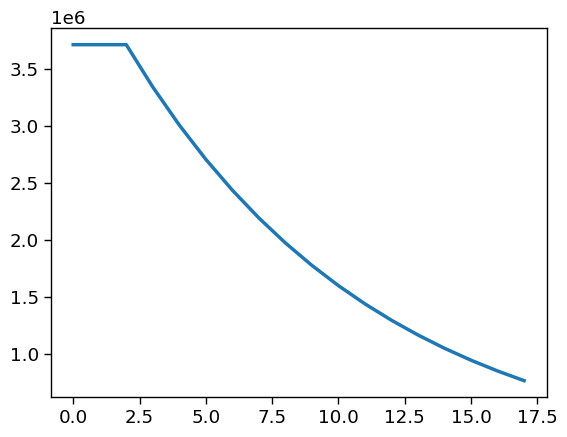

In [16]:
plt.plot(emission_budget)


In [17]:
# money budget

money_budget = [.5e5 for t in range(timeHorizon+1)]

# disctance budget

distance_budget = [mpkm for t in range(timeHorizon+1)]
print(distance_budget[-1])

27005.313488805332


# Optimisation

## Linear Model

In [18]:
class TransportModel:
    def __init__(self, T, 
                list_modes, initial_modes, total_km,
                initial_infra : dict, depreciation_infra : dict, 
                list_vehicle, initial_vehicle : dict, initial_vehicle_with_age : dict, average_distance_per_vehicle : dict, expected_lifetime_vehicle : dict,
                emission_per_km_vehicle, emission_per_km_mode,
                cost_sobriety, cost_vehicle_switch, cost_vehicule_buy, cost_modes_switch, cost_infra_invest,  
                service_quality, 
                emission_budget, money_budget):
        
        # Create a Concrete Model
        self.m = ConcreteModel()

        # Parameters
        self.m.T = T
        self.m.list_modes = list_modes
        self.m.list_infra = [i for i in list_modes if i != 'sobriety']
        self.m.initial_modes = initial_modes
        self.m.total_km = total_km # million passenger-kmn (mpkm)
        self.m.initial_infra = initial_infra 
        self.m.depreciation_infra = depreciation_infra
        self.m.list_vehicle = list_vehicle
        self.m.initial_vehicle = initial_vehicle
        self.m.initial_vehicle_with_age = initial_vehicle_with_age
        self.m.average_distance_per_vehicle = average_distance_per_vehicle # km
        self.m.expected_lifetime_vehicle = expected_lifetime_vehicle # years
        self.m.emission_per_km_vehicle = emission_per_km_vehicle # tCO2e/vehicle-mkm
        self.m.emission_per_km_mode = emission_per_km_mode # tCO2e/mode-mkm
        self.m.cost_sobriety = cost_sobriety # €
        self.m.cost_vehicle_switch = cost_vehicle_switch # €/vehicle
        self.m.cost_vehicule_buy = cost_vehicule_buy # €/vehicle
        self.m.cost_modes_switch = cost_modes_switch # €
        self.m.cost_infra_invest = cost_infra_invest # €
        self.m.service_quality = service_quality 

        # Budget

        self.m.emission_budget = emission_budget
        self.m.money_budget = money_budget

        # Sets
        self.m.time = RangeSet(0, T)

        # Usage 
        self.m.modes = Set(initialize=list_modes) # marche, velo, train, tram, bus, voiture
        self.m.usage = Var(self.m.modes, self.m.time, domain=NonNegativeReals) # passenger-km
        self.m.usage_proportion = Var(self.m.modes, self.m.time, domain=NonNegativeReals, bounds=(0,1)) # proportion of usage of each mode
        self.m.switch = Var(self.m.modes, self.m.modes, self.m.time, bounds=(0,0.05), domain=NonNegativeReals, initialize=0) # switch from one mode to another 

        # Infrastucture
        self.m.infra = Set(initialize=self.m.list_infra)
        self.m.infra_park = Var(self.m.infra, self.m.time, domain=NonNegativeReals) # vehicle-km
        self.m.infra_invest = Var(self.m.infra, self.m.time, domain=NonNegativeReals, initialize=0) # investment in infrastructure

        # Vehicule 
        self.m.vehicle = Set(initialize=list_vehicle)
        self.m.vehicle_park = Var(self.m.vehicle, self.m.time, domain=NonNegativeReals) # vehicle
        self.m.vehicle_buy = Var(self.m.vehicle, self.m.time, domain=NonNegativeReals, initialize=0) # vehicle buy 
        self.m.vehicle_switch = Var(self.m.vehicle, self.m.vehicle, self.m.time, domain=NonNegativeReals, initialize=0) # switch from one vehicle to another at end of life 
    

    def build_initial_conditions(self):
        # Initial conditions
        self.m.init_conditions = ConstraintList()
        for mode in self.m.list_modes:
            if mode != 'sobriety':
                self.m.init_conditions.add(self.m.usage_proportion[mode, 0] == self.m.initial_modes[mode])
            else:
                self.m.init_conditions.add(self.m.usage_proportion[mode, 0] == 0)

        for infra in self.m.list_infra:
            self.m.init_conditions.add(self.m.infra_park[infra, 0] == self.m.initial_infra[infra])

        for vehicle in self.m.vehicle:
            self.m.init_conditions.add(self.m.vehicle_park[vehicle, 0] == self.m.initial_vehicle[vehicle])

    def build_constraints(self):
        # Constraints

        # Link between usage and usage proportion
        self.m.link_usage_usage_proportion = ConstraintList()
        for mode in self.m.list_modes:
            for t in self.m.time:
                self.m.link_usage_usage_proportion.add(self.m.usage[mode, t] == self.m.usage_proportion[mode, t] * self.m.total_km[t])
        
        # Dynamics
        self.m.dynamics = ConstraintList()
        for mode in list_modes:
            for t in range(1, self.m.T+1):
                # Proportion of usage of each mode, at each time t, is equal to the proportion of usage of each mode at time t-1 + the switch from other modes to mode i - the switch from mode i to other modes
                self.m.dynamics.add(self.m.usage_proportion[mode, t] == self.m.usage_proportion[mode, t-1]\
                     + sum(self.m.switch[j, mode, t] for j in self.m.modes) - sum(self.m.switch[mode, j, t] for j in self.m.modes) )
            
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                # Usage of each infra, at each time t, is equal to the proportion of usage of each infra at time t * mpkm, where mpkm is the total km passenger want to travel 
                self.m.dynamics.add(self.m.infra_park[infra, t] == self.m.infra_park[infra, t-1] * self.m.depreciation_infra[infra]  + self.m.infra_invest[infra, t])

        for vehicle in self.m.vehicle:
            for t in range(1, self.m.T+1):
                if t <= self.m.expected_lifetime_vehicle[vehicle]:
                    # Evolution of the number of vehicle in circulation, at each time t, is equal to the number of vehicle in circulation at time t-1 + the number of vehicle bought at time t + the number of vehicle switched to vehicle i - the number of vehicle that are at the end of their life
                    self.m.dynamics.add(self.m.vehicle_park[vehicle, t] == self.m.vehicle_park[vehicle, t-1] \
                                            + self.m.vehicle_buy[vehicle, t] + sum(self.m.vehicle_switch[j, vehicle, t] for j in self.m.vehicle) \
                                            - self.m.initial_vehicle_with_age[vehicle][t-1]
                                            )
                else:
                    # Evolution of the number of vehicle in circulation, at each time t, is equal to the number of vehicle in circulation at time t-1 - the number of vehicle that are at the end of their life + the number of vehicle bought at time t + the number of vehicle switched to vehicle i
                    self.m.dynamics.add(self.m.vehicle_park[vehicle, t] == self.m.vehicle_park[vehicle, t-1] \
                                            - self.m.vehicle_buy[vehicle, t-self.m.expected_lifetime_vehicle[vehicle]] - sum(self.m.vehicle_switch[j, vehicle, t-self.m.expected_lifetime_vehicle[vehicle]] for j in self.m.vehicle) \
                                            + self.m.vehicle_buy[vehicle, t] + sum(self.m.vehicle_switch[j, vehicle, t] for j in self.m.vehicle)
                                            )
                    
        # Capacity
        self.m.capacity = ConstraintList()
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                if infra == 'voiture' :
                    # At each time t, the number of vehicle in circulation is less than the capacity of the infrastructure
                    self.m.capacity.add(
                        sum(self.m.vehicle_park[j, t] * self.m.average_distance_per_vehicle[j] for j in self.m.vehicle) <= self.m.infra_park[infra, t]
                        )
                else:
                    # At each time t, the usage of mode i is less than the capacity of the infrastructure
                    self.m.capacity.add(
                        self.m.usage[infra, t] <= self.m.infra_park[infra, t]
                        )

        # Vehicle constraints
        self.m.vehicle_constraints = ConstraintList()
        for vehicle in self.m.vehicle:
            for t in range(1, self.m.T+1):
                if t <= self.m.expected_lifetime_vehicle[vehicle]:
                    # At each time t, the number of vehicle that are switched to vehicle i is less than the number of vehicle that are at the end of their life
                    self.m.vehicle_constraints.add(
                        sum(self.m.vehicle_switch[vehicle, j, t] for j in self.m.vehicle) <= self.m.initial_vehicle_with_age[vehicle][self.m.expected_lifetime_vehicle[vehicle]-t]
                        )
                else:
                    # At each time t, the number of vehicle that are switched to vehicle i is less than the number of vehicle that are bought at time t-expected_lifetime_vehicle[i]
                    self.m.vehicle_constraints.add(
                        sum(self.m.vehicle_switch[vehicle, j, t] for j in self.m.vehicle) <= self.m.vehicle_buy[vehicle, t-self.m.expected_lifetime_vehicle[vehicle]]
                        )
                    
        # Mobility constraint
        self.m.mobility_constraint = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the usage of car is less than the number of vehicle in circulation (to avoid having usage of car without car in circulation)
            self.m.mobility_constraint.add(
                self.m.usage['voiture', t] <= sum(self.m.vehicle_park[i, t] * self.m.average_distance_per_vehicle[i] * 1.3 for i in self.m.vehicle)
                )
            
        # Budget constraints

        self.m.budget_constraint = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the emission is less than the emission budget
            self.m.budget_constraint.add(
                self.emission_expression(t) <= emission_budget[t]
                )
            # At each time t, the money spent is less than the money budget
            self.m.budget_constraint.add(
                self.money_expression(t) <= money_budget[t]
                )
            
        # # Constraints on modes
        self.m.mode_constraints = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the usage of marche is less than 5% of the total km
            self.m.mode_constraints.add(
                self.m.usage_proportion['marche', t] <= 0.05
                )
            # At each time t, the usage of velo is less than 20% of the total km
            self.m.mode_constraints.add(
                self.m.usage['velo', t] <= 0.02 * self.m.total_km[t]* 1.1**t
                )
        
    def emission_expression(self, t):
        return sum(self.m.usage[i, t] * self.m.emission_per_km_mode[i] for i in self.m.modes if i != 'voiture')\
              + sum(self.m.vehicle_park[i, t] * self.m.emission_per_km_vehicle[i] * self.m.average_distance_per_vehicle[i] for i in self.m.vehicle)
    
    def money_expression(self, t):
        return sum(self.m.infra_invest[i, t] * self.m.cost_infra_invest[i] for i in self.m.infra) \
            + sum(self.m.vehicle_switch[i,j,t] * self.m.cost_vehicle_switch[i][j] for i in self.m.vehicle for j in self.m.vehicle) \
            + sum(self.m.vehicle_buy[i,t] * self.m.cost_vehicule_buy[i] for i in self.m.vehicle) \
            + sum(self.m.switch[i,j,t] * self.m.cost_modes_switch[i][j] for i in self.m.modes for j in self.m.modes)
            # + self.m.usage['sobriety',t] * self.m.cost_sobriety \
    
    def objective_function(self, m):
        return sum(self.m.usage[i, t] * self.m.service_quality[i] for i in self.m.modes if i != 'voiture' for t in self.m.time) \
                + sum(self.m.usage['voiture', t] for t in self.m.time) * self.m.service_quality['voiture'] \
                 - sum(self.m.usage['sobriety', t] for t in self.m.time) 
    


    
    def build_model(self):
        self.build_initial_conditions()
        self.build_constraints()
        self.m.obj = Objective(rule=self.objective_function(self.m), sense=maximize)

    def solve(self):
        with SolverFactory("mosek") as solver:
            # options - MOSEK parameters dictionary, using strings as keys (optional)
            # tee - write log output if True (optional)
            # soltype - accepts three values : bas, itr and itg for basic,
            # interior point and integer solution, respectively. (optional)
            results = solver.solve(self.m, options = {
                                        # 'dparam.optimizer_max_time':  100.0, 
                                        # 'iparam.intpnt_solve_form':   int(mosek.solveform.dual)
                                        },
                                tee = False, soltype='itr')

            # Print the status of the solved 
            print(results.solver.status)    
            print(results)    
    




In [19]:

# Create the model
model = TransportModel(timeHorizon, 
                       list_modes, dict_modes, distance_budget,
                       dict_infra, dict_depreciation_infra, 
                       list_vehicule, dict_vehicle_total, dict_vehicule_region, dict_distance_moyenne_vehicle, duree_de_vie_vehicule, dict_emission_vehicule,
                       dict_emission, cost_sobriety=cout_sob, cost_vehicle_switch=couts_switch_vehicule, cost_vehicule_buy=dict_couts_achat_vehicule, cost_modes_switch=couts_switch_modes, cost_infra_invest=dict_couts_invest_infra,
                          service_quality=dict_qualite_service, emission_budget=emission_budget, money_budget=money_budget)

In [20]:
model.build_model()
model.solve()

ok

Problem: 
- Name: 
  Lower bound: 377318.2162019827
  Upper bound: 377318.21620198304
  Number of objectives: 1
  Number of constraints: 578
  Number of variables: 1440
  Number of integer variables: 0
  Number of continuous variables: 1440
  Number of nonzeros: 3075
  Sense: maximize
  Number of solutions: 1
Solver: 
- Name: MOSEK 10.1.31
  Status: ok
  Wallclock time: 0.047
  Termination condition: optimal
  Termination message:  Model was solved to optimality and an optimal solution is available.
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



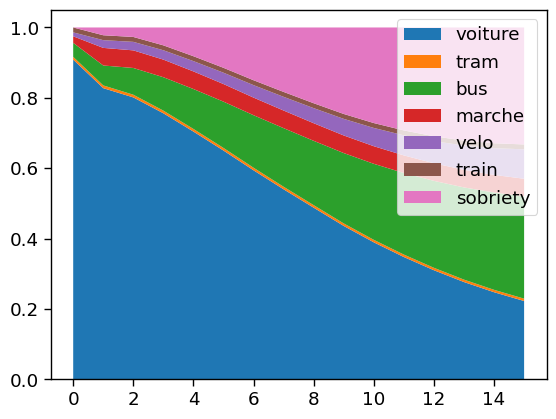

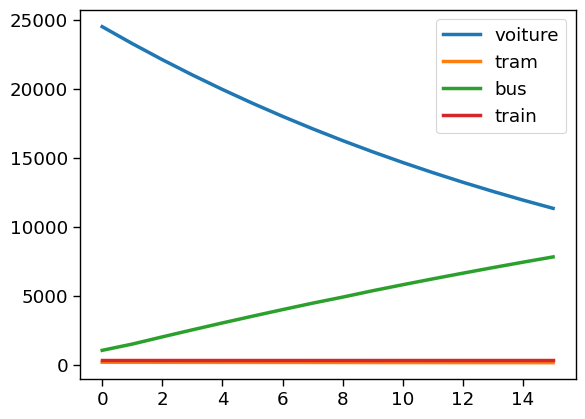

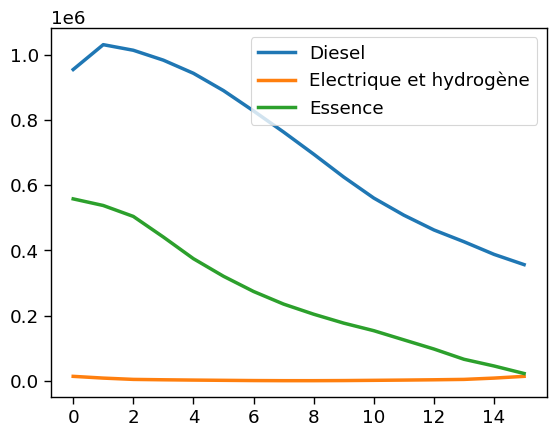

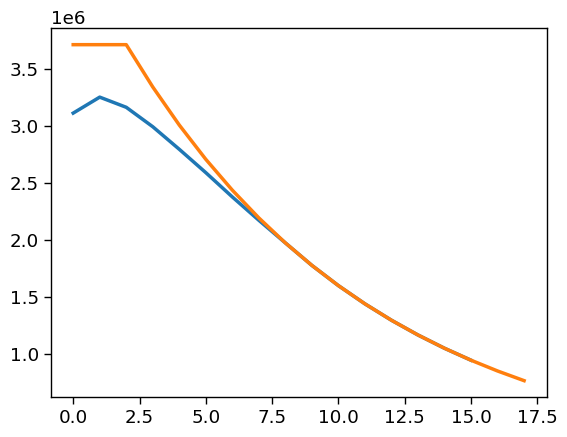

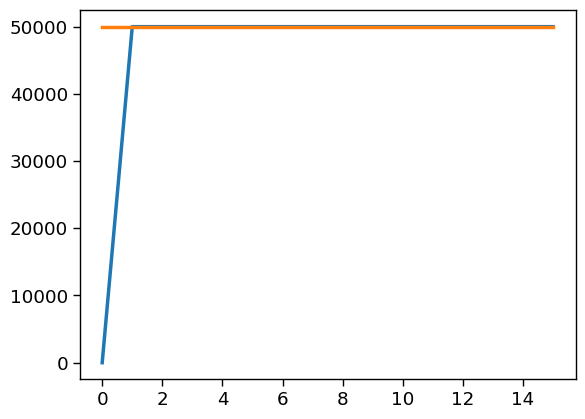

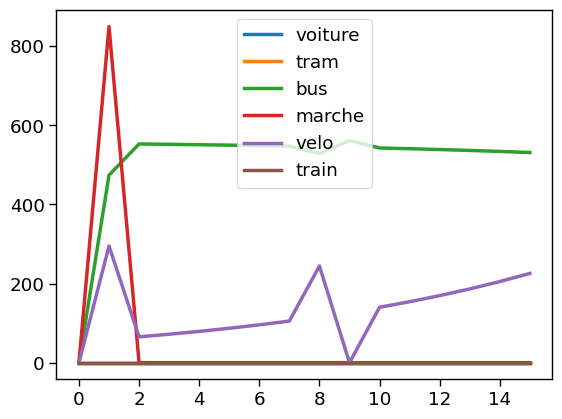

In [21]:
# Plot the results
# as staked plot

data_to_stack = np.array([[model.m.usage[mode, t].value for t in model.m.time] for mode in model.m.modes])/mpkm

plt.stackplot(model.m.time, data_to_stack)
plt.legend(model.m.modes)
plt.show()


plt.plot([model.m.infra_park['voiture', t].value for t in model.m.time])
plt.plot([model.m.infra_park['tram', t].value for t in model.m.time])
plt.plot([model.m.infra_park['bus', t].value for t in model.m.time])
plt.plot([model.m.infra_park['train', t].value for t in model.m.time])
plt.legend(['voiture', 'tram', 'bus', 'train'])
plt.show()

plt.plot([model.m.vehicle_park['Diesel', t].value for t in model.m.time])
plt.plot([model.m.vehicle_park['Electrique et hydrogène', t].value for t in model.m.time])
plt.plot([model.m.vehicle_park['Essence', t].value for t in model.m.time])
plt.legend(['Diesel', 'Electrique et hydrogène', 'Essence'])
plt.show()

plt.plot([value(model.emission_expression(t)) for t in model.m.time])
plt.plot(emission_budget)
plt.show()

plt.plot([value(model.money_expression(t)) for t in model.m.time])
plt.plot(money_budget)
plt.show()

# plt the investment in infrastructure
data_to_plot = np.array([[model.m.infra_invest[infra, t].value for t in model.m.time] for infra in model.m.list_infra])
plt.plot(model.m.time, data_to_plot.T)
plt.legend(model.m.list_infra)
plt.show()


## Linear model with change

27005.313488805332


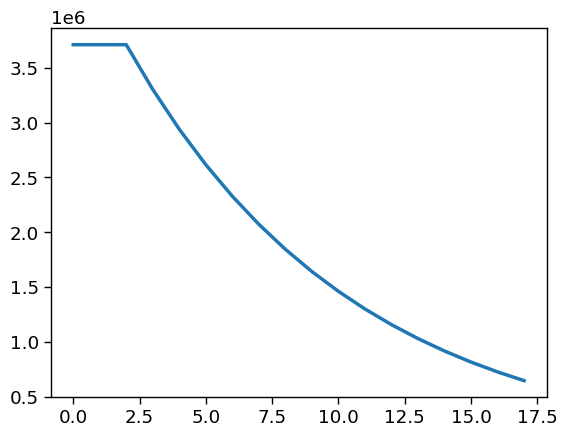

In [22]:
timeHorizon = 15
list_vehicule = ['Diesel', 'Electrique et hydrogène', 'Essence']
# emission budget

# initial emission budget as the emission of the region in 2019 in tCO2 
initial_emission_budget = np.sum([dict_emission[i] * dict_modes[i] for i in list_modes if not (i in ['voiture', 'sobriety'])])\
      + np.sum([dict_emission_vehicule[i] * dict_vehicle_total[i] * dict_distance_moyenne_vehicle[i] for i in list_vehicule])

initial_emission_budget = 1.2* initial_emission_budget

# each years the emission budget decrease by 10% 
emission_budget = [initial_emission_budget] *2+  [initial_emission_budget * (0.89)**(t) for t in range(timeHorizon+1)]
plt.plot(emission_budget)
# money budget

money_budget = [1e4 for t in range(timeHorizon+1)]

# disctance budget

distance_budget = [mpkm for t in range(timeHorizon+1)]
print(distance_budget[-1])

In [23]:
class TransportModel:
    def __init__(self, T, 
                list_modes, initial_modes, total_km,
                initial_infra : dict, depreciation_infra : dict, 
                list_vehicle, initial_vehicle : dict, initial_vehicle_with_age : dict, average_distance_per_vehicle : dict, expected_lifetime_vehicle : dict,
                emission_per_km_vehicle, emission_per_km_mode,
                cost_sobriety, cost_vehicle_switch, cost_vehicule_buy, cost_modes_switch, cost_infra_invest,  
                service_quality, 
                emission_budget, money_budget):
        
        # Create a Concrete Model
        self.m = ConcreteModel()

        # Parameters
        self.m.T = T
        self.m.list_modes = list_modes
        self.m.list_infra = [i for i in list_modes if i != 'sobriety']
        self.m.initial_modes = initial_modes
        self.m.total_km = total_km # million passenger-kmn (mpkm)
        self.m.initial_infra = initial_infra 
        self.m.depreciation_infra = depreciation_infra
        self.m.list_vehicle = list_vehicle
        self.m.initial_vehicle = initial_vehicle
        self.m.initial_vehicle_with_age = initial_vehicle_with_age
        self.m.average_distance_per_vehicle = average_distance_per_vehicle # km
        self.m.expected_lifetime_vehicle = expected_lifetime_vehicle # years
        self.m.emission_per_km_vehicle = emission_per_km_vehicle # tCO2e/vehicle-mkm
        self.m.emission_per_km_mode = emission_per_km_mode # tCO2e/mode-mkm
        self.m.cost_sobriety = cost_sobriety # €
        self.m.cost_vehicle_switch = cost_vehicle_switch # €/vehicle
        self.m.cost_vehicule_buy = cost_vehicule_buy # €/vehicle
        self.m.cost_modes_switch = cost_modes_switch # €
        self.m.cost_infra_invest = cost_infra_invest # €
        self.m.service_quality = service_quality 

        # Budget

        self.m.emission_budget = emission_budget
        self.m.money_budget = money_budget

        # Sets
        self.m.time = RangeSet(0, T)

        # Usage 
        self.m.modes = Set(initialize=list_modes) # marche, velo, train, tram, bus, voiture
        self.m.usage = Var(self.m.modes, self.m.time, domain=NonNegativeReals) # passenger-km
        self.m.usage_proportion = Var(self.m.modes, self.m.time, domain=NonNegativeReals, bounds=(0,1)) # proportion of usage of each mode
        self.m.switch = Var(self.m.modes, self.m.modes, self.m.time, bounds=(0,0.05), domain=NonNegativeReals, initialize=0) # switch from one mode to another 

        # Infrastucture
        self.m.infra = Set(initialize=self.m.list_infra)
        def _bounds_rule(m, infra, time):
            return (m.initial_infra[infra] * m.depreciation_infra[infra]**time, m.initial_infra[infra] * 1.1**time)
        self.m.infra_park = Var(self.m.infra, self.m.time, domain=NonNegativeReals, bounds=_bounds_rule)
        self.m.infra_invest = Var(self.m.infra, self.m.time, domain=NonNegativeReals, initialize=0) # investment in infrastructure

        # Vehicule 
        self.m.vehicle = Set(initialize=list_vehicle)
        self.m.vehicle_park = Var(self.m.vehicle, self.m.time, domain=NonNegativeReals) # vehicle
        self.m.vehicle_buy = Var(self.m.vehicle, self.m.time, domain=NonNegativeReals, initialize=0) # vehicle buy 
        self.m.vehicle_switch = Var(self.m.vehicle, self.m.vehicle, self.m.time, domain=NonNegativeReals, initialize=0) # switch from one vehicle to another at end of life 
    

    def build_initial_conditions(self):
        # Initial conditions
        self.m.init_conditions = ConstraintList()
        for mode in self.m.list_modes:
            if mode != 'sobriety':
                self.m.init_conditions.add(self.m.usage_proportion[mode, 0] == self.m.initial_modes[mode])
            else:
                self.m.init_conditions.add(self.m.usage_proportion[mode, 0] == 0)

        for infra in self.m.list_infra:
            self.m.init_conditions.add(self.m.infra_park[infra, 0] == self.m.initial_infra[infra])

        for vehicle in self.m.vehicle:
            self.m.init_conditions.add(self.m.vehicle_park[vehicle, 0] == self.m.initial_vehicle[vehicle])

    def build_constraints(self):
        # Constraints

        # Link between usage and usage proportion
        self.m.link_usage_usage_proportion = ConstraintList()
        for mode in self.m.list_modes:
            for t in self.m.time:
                self.m.link_usage_usage_proportion.add(self.m.usage[mode, t] == self.m.usage_proportion[mode, t] * self.m.total_km[t])
        
        # Dynamics
        self.m.dynamics = ConstraintList()
        for mode in list_modes:
            for t in range(1, self.m.T+1):
                # Proportion of usage of each mode, at each time t, is equal to the proportion of usage of each mode at time t-1 + the switch from other modes to mode i - the switch from mode i to other modes
                self.m.dynamics.add(self.m.usage_proportion[mode, t] == self.m.usage_proportion[mode, t-1]\
                     + sum(self.m.switch[j, mode, t] for j in self.m.modes) - sum(self.m.switch[mode, j, t] for j in self.m.modes) )
            
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                # Usage of each infra, at each time t, is equal to the proportion of usage of each infra at time t * mpkm, where mpkm is the total km passenger want to travel 
                self.m.dynamics.add(self.m.infra_park[infra, t] == self.m.infra_park[infra, t-1] * self.m.depreciation_infra[infra]  + self.m.infra_invest[infra, t])

        for vehicle in self.m.vehicle:
            for t in range(1, self.m.T+1):
                if t <= self.m.expected_lifetime_vehicle[vehicle]:
                    # Evolution of the number of vehicle in circulation, at each time t, is equal to the number of vehicle in circulation at time t-1 + the number of vehicle bought at time t + the number of vehicle switched to vehicle i - the number of vehicle that are at the end of their life
                    self.m.dynamics.add(self.m.vehicle_park[vehicle, t] == self.m.vehicle_park[vehicle, t-1] \
                                            + self.m.vehicle_buy[vehicle, t] + sum(self.m.vehicle_switch[j, vehicle, t] for j in self.m.vehicle) \
                                            - self.m.initial_vehicle_with_age[vehicle][t-1]
                                            )
                else:
                    # Evolution of the number of vehicle in circulation, at each time t, is equal to the number of vehicle in circulation at time t-1 - the number of vehicle that are at the end of their life + the number of vehicle bought at time t + the number of vehicle switched to vehicle i
                    self.m.dynamics.add(self.m.vehicle_park[vehicle, t] == self.m.vehicle_park[vehicle, t-1] \
                                            - self.m.vehicle_buy[vehicle, t-self.m.expected_lifetime_vehicle[vehicle]] - sum(self.m.vehicle_switch[j, vehicle, t-self.m.expected_lifetime_vehicle[vehicle]] for j in self.m.vehicle) \
                                            + self.m.vehicle_buy[vehicle, t] + sum(self.m.vehicle_switch[j, vehicle, t] for j in self.m.vehicle)
                                            )
                    
        # Capacity
        self.m.capacity = ConstraintList()
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                if infra == 'voiture' :
                    # At each time t, the number of vehicle in circulation is less than the capacity of the infrastructure
                    self.m.capacity.add(
                        sum(self.m.vehicle_park[j, t] * self.m.average_distance_per_vehicle[j] for j in self.m.vehicle) <= self.m.infra_park[infra, t]
                        )
                else:
                    # At each time t, the usage of mode i is less than the capacity of the infrastructure
                    self.m.capacity.add(
                        self.m.usage[infra, t] <= self.m.infra_park[infra, t]
                        )

        # Vehicle constraints
        self.m.vehicle_constraints = ConstraintList()
        for vehicle in self.m.vehicle:
            for t in range(1, self.m.T+1):
                if t <= self.m.expected_lifetime_vehicle[vehicle]:
                    # At each time t, the number of vehicle that are switched to vehicle i is less than the number of vehicle that are at the end of their life
                    self.m.vehicle_constraints.add(
                        sum(self.m.vehicle_switch[vehicle, j, t] for j in self.m.vehicle) <= self.m.initial_vehicle_with_age[vehicle][self.m.expected_lifetime_vehicle[vehicle]-t]
                        )
                else:
                    # At each time t, the number of vehicle that are switched to vehicle i is less than the number of vehicle that are bought at time t-expected_lifetime_vehicle[i]
                    self.m.vehicle_constraints.add(
                        sum(self.m.vehicle_switch[vehicle, j, t] for j in self.m.vehicle) <= self.m.vehicle_buy[vehicle, t-self.m.expected_lifetime_vehicle[vehicle]]
                        )
                    
        # Mobility constraint
        self.m.mobility_constraint = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the usage of car is less than the number of vehicle in circulation (to avoid having usage of car without car in circulation)
            self.m.mobility_constraint.add(
                self.m.usage['voiture', t] <= sum(self.m.vehicle_park[i, t] * self.m.average_distance_per_vehicle[i] * 1.3 for i in self.m.vehicle)
                )
            
        # Budget constraints

        self.m.budget_constraint = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the emission is less than the emission budget
            self.m.budget_constraint.add(
                self.emission_expression(t) <= emission_budget[t]
                )
            # At each time t, the money spent is less than the money budget
            self.m.budget_constraint.add(
                self.money_expression(t) <= money_budget[t]
                )
            
        # # Constraints on modes
        self.m.mode_constraints = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the usage of marche is less than 5% of the total km
            self.m.mode_constraints.add(
                self.m.usage_proportion['marche', t] <= 0.05
                )
            
            self.m.mode_constraints.add(
                self.m.usage_proportion['marche', t] >= 0.005 
                )


            # At each time t, the usage of velo is less than 20% of the total km
            self.m.mode_constraints.add(
                self.m.usage['velo', t] <= 0.02 * self.m.total_km[t]* 1.1**t
                )

        self.m.infra_invest_constraint = ConstraintList()
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                self.m.infra_invest_constraint.add(self.m.infra_invest[infra, t] <= self.m.infra_park[infra, t] * 0.1)
            
        
    def emission_expression(self, t):
        return sum(self.m.usage[i, t] * self.m.emission_per_km_mode[i] for i in self.m.modes if i != 'voiture')\
              + sum(self.m.vehicle_park[i, t] * self.m.emission_per_km_vehicle[i] * self.m.average_distance_per_vehicle[i] for i in self.m.vehicle)
    
    def money_expression(self, t):
        return sum(self.m.infra_invest[i, t] * self.m.cost_infra_invest[i] for i in self.m.infra) \
            + sum(self.m.vehicle_switch[i,j,t] * self.m.cost_vehicle_switch[i][j] for i in self.m.vehicle for j in self.m.vehicle) \
            + sum(self.m.vehicle_buy[i,t] * self.m.cost_vehicule_buy[i] for i in self.m.vehicle) \
            + self.m.usage['sobriety',t] * self.m.cost_sobriety \
            + sum(self.m.switch[i,j,t] * self.m.cost_modes_switch[i][j] for i in self.m.modes for j in self.m.modes)
    
    def objective_function(self, m):
        return sum(self.m.usage[i, t] * self.m.service_quality[i] for i in self.m.modes if i != 'voiture' for t in self.m.time) \
                + sum(self.m.usage['voiture', t] for t in self.m.time) * self.m.service_quality['voiture'] \
                 - sum(self.m.usage['sobriety', t] for t in self.m.time) *20
    


    
    def build_model(self):
        self.build_initial_conditions()
        self.build_constraints()
        self.m.obj = Objective(rule=self.objective_function(self.m), sense=maximize)

    def solve(self):
        with SolverFactory("mosek") as solver:
            # options - MOSEK parameters dictionary, using strings as keys (optional)
            # tee - write log output if True (optional)
            # soltype - accepts three values : bas, itr and itg for basic,
            # interior point and integer solution, respectively. (optional)
            results = solver.solve(self.m, options = {
                                        # 'dparam.optimizer_max_time':  100.0, 
                                        # 'iparam.intpnt_solve_form':   int(mosek.solveform.dual)
                                        },
                                tee = False, soltype='itr')

            # Print the status of the solved 
            print(results.solver.status)    
            print(results)    
    




In [24]:

# Create the model
model = TransportModel(timeHorizon, 
                       list_modes, dict_modes, distance_budget,
                       dict_infra, dict_depreciation_infra, 
                       list_vehicule, dict_vehicle_total, dict_vehicule_region, dict_distance_moyenne_vehicle, duree_de_vie_vehicule, dict_emission_vehicule,
                       dict_emission, cost_sobriety=cout_sob, cost_vehicle_switch=couts_switch_vehicule, cost_vehicule_buy=dict_couts_achat_vehicule, cost_modes_switch=couts_switch_modes, cost_infra_invest=dict_couts_invest_infra,
                          service_quality=dict_qualite_service, emission_budget=emission_budget, money_budget=money_budget)
model.build_model()


model.solve()

ok

Problem: 
- Name: 
  Lower bound: -2619790.901877888
  Upper bound: -2619790.901877893
  Number of objectives: 1
  Number of constraints: 683
  Number of variables: 1440
  Number of integer variables: 0
  Number of continuous variables: 1440
  Number of nonzeros: 3285
  Sense: maximize
  Number of solutions: 1
Solver: 
- Name: MOSEK 10.1.31
  Status: ok
  Wallclock time: 0.062
  Termination condition: optimal
  Termination message:  Model was solved to optimality and an optimal solution is available.
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



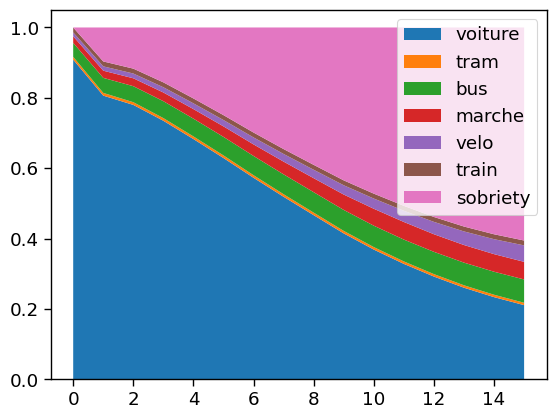

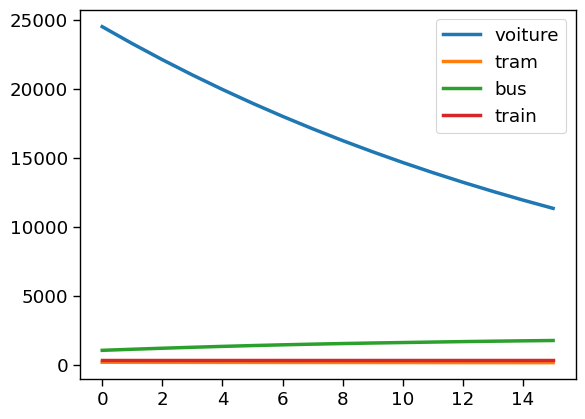

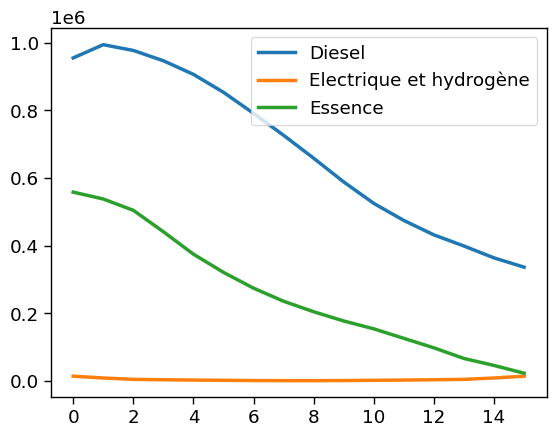

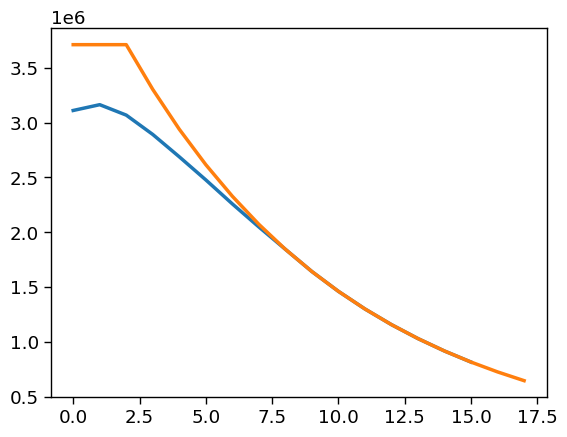

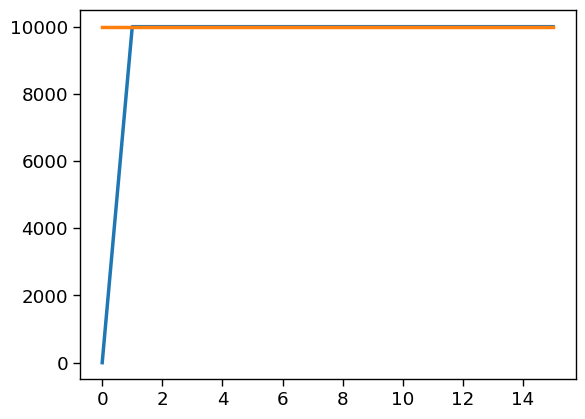

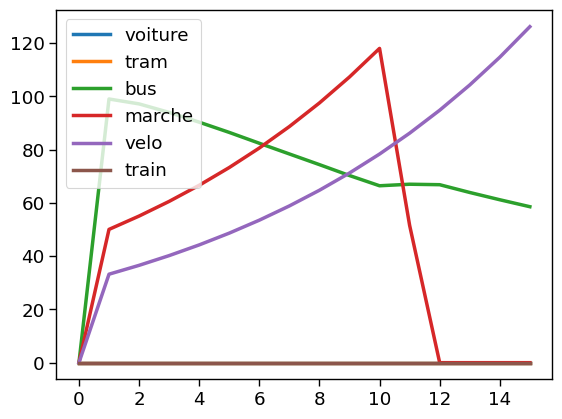

In [25]:
# Plot the results
import matplotlib.pyplot as plt

# as staked plot

data_to_stack = np.array([[model.m.usage[mode, t].value for t in model.m.time] for mode in model.m.modes])/mpkm

plt.stackplot(model.m.time, data_to_stack)
plt.legend(model.m.modes)
plt.show()


plt.plot([model.m.infra_park['voiture', t].value for t in model.m.time])
plt.plot([model.m.infra_park['tram', t].value for t in model.m.time])
plt.plot([model.m.infra_park['bus', t].value for t in model.m.time])
plt.plot([model.m.infra_park['train', t].value for t in model.m.time])
plt.legend(['voiture', 'tram', 'bus', 'train'])
plt.show()

plt.plot([model.m.vehicle_park['Diesel', t].value for t in model.m.time])
plt.plot([model.m.vehicle_park['Electrique et hydrogène', t].value for t in model.m.time])
plt.plot([model.m.vehicle_park['Essence', t].value for t in model.m.time])
plt.legend(['Diesel', 'Electrique et hydrogène', 'Essence'])
plt.show()

plt.plot([value(model.emission_expression(t)) for t in model.m.time])
plt.plot(emission_budget)
plt.show()

plt.plot([value(model.money_expression(t)) for t in model.m.time])
plt.plot(money_budget)
plt.show()

# plt the investment in infrastructure
data_to_plot = np.array([[model.m.infra_invest[infra, t].value for t in model.m.time] for infra in model.m.list_infra])
plt.plot(model.m.time, data_to_plot.T)
plt.legend(model.m.list_infra)
plt.show()


## Non-linear model with car park change

27005.313488805332


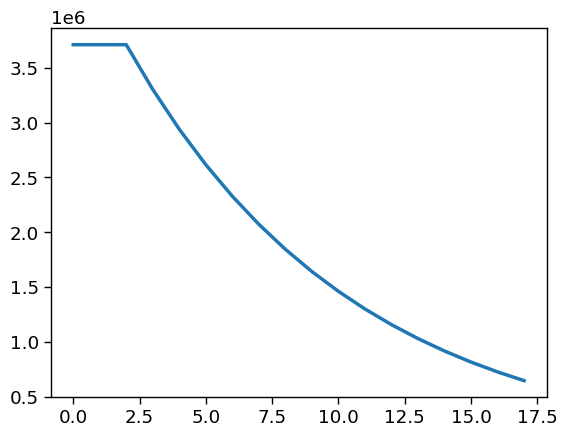

In [26]:
timeHorizon = 15
list_vehicule = ['Diesel', 'Electrique et hydrogène', 'Essence']
# emission budget

# initial emission budget as the emission of the region in 2019 in tCO2 
initial_emission_budget = np.sum([dict_emission[i] * dict_modes[i] for i in list_modes if not (i in ['voiture', 'sobriety'])])\
      + np.sum([dict_emission_vehicule[i] * dict_vehicle_total[i] * dict_distance_moyenne_vehicle[i] for i in list_vehicule])

initial_emission_budget = 1.2* initial_emission_budget

# each years the emission budget decrease by 10% 
emission_budget = [initial_emission_budget] *2+  [initial_emission_budget * (0.89)**(t) for t in range(timeHorizon+1)]
plt.plot(emission_budget)
# money budget

money_budget = [.5e4 for t in range(timeHorizon+1)]

# disctance budget

distance_budget = [mpkm for t in range(timeHorizon+1)]
print(distance_budget[-1])

In [27]:

class TransportModel:
    def __init__(self, T, 
                list_modes, initial_modes, total_km,
                initial_infra : dict, depreciation_infra : dict, 
                list_vehicle, initial_vehicle : dict, initial_vehicle_with_age : dict, average_distance_per_vehicle : dict, expected_lifetime_vehicle : dict,
                emission_per_km_vehicle, emission_per_km_mode,
                cost_sobriety, cost_vehicle_switch, cost_vehicule_buy, cost_modes_switch, cost_infra_invest,  
                service_quality, 
                emission_budget, money_budget):
        
        # Create a Concrete Model
        self.m = ConcreteModel()

        # Parameters
        self.m.T = T
        self.m.list_modes = list_modes
        self.m.list_infra = [i for i in list_modes if i != 'sobriety']
        self.m.initial_modes = initial_modes
        self.m.total_km = total_km # million passenger-kmn (mpkm)
        self.m.initial_infra = initial_infra 
        self.m.depreciation_infra = depreciation_infra
        self.m.list_vehicle = list_vehicle
        self.m.initial_vehicle = initial_vehicle
        self.m.initial_vehicle_with_age = initial_vehicle_with_age
        self.m.average_distance_per_vehicle = average_distance_per_vehicle # km
        self.m.expected_lifetime_vehicle = expected_lifetime_vehicle # years
        self.m.emission_per_km_vehicle = emission_per_km_vehicle # tCO2e/vehicle-mkm
        self.m.emission_per_km_mode = emission_per_km_mode # tCO2e/mode-mkm
        self.m.cost_sobriety = cost_sobriety # €
        self.m.cost_vehicle_switch = cost_vehicle_switch # €/vehicle
        self.m.cost_vehicule_buy = cost_vehicule_buy # €/vehicle
        self.m.cost_modes_switch = cost_modes_switch # €
        self.m.cost_infra_invest = cost_infra_invest # €
        self.m.service_quality = service_quality 

        # Budget

        self.m.emission_budget = emission_budget
        self.m.money_budget = money_budget

        # Sets
        self.m.time = RangeSet(0, T)

        # Usage 
        self.m.modes = Set(initialize=list_modes) # marche, velo, train, tram, bus, voiture
        self.m.usage = Var(self.m.modes, self.m.time, domain=NonNegativeReals) # passenger-km
        self.m.usage_proportion = Var(self.m.modes, self.m.time, domain=NonNegativeReals, bounds=(0,1)) # proportion of usage of each mode
        self.m.switch = Var(self.m.modes, self.m.modes, self.m.time, bounds=(0,0.05), domain=NonNegativeReals, initialize=0) # switch from one mode to another 

        # Infrastucture
        self.m.infra = Set(initialize=self.m.list_infra)
        def _bounds_rule(m, infra, time):
            return (m.initial_infra[infra] * m.depreciation_infra[infra]**time, m.initial_infra[infra] * 1.1**time)
        self.m.infra_park = Var(self.m.infra, self.m.time, domain=NonNegativeReals, bounds=_bounds_rule)
        self.m.infra_invest = Var(self.m.infra, self.m.time, domain=NonNegativeReals, initialize=0) # investment in infrastructure

        # Vehicule 
        self.m.vehicle = Set(initialize=list_vehicle)
        self.m.vehicle_park = Var(self.m.vehicle, self.m.time, domain=NonNegativeReals) # vehicle
        self.m.vehicle_buy = Var(self.m.vehicle, self.m.time, domain=NonNegativeReals, initialize=0) # vehicle buy 
        self.m.vehicle_switch = Var(self.m.vehicle, self.m.vehicle, self.m.time, domain=NonNegativeReals, initialize=0) # switch from one vehicle to another at end of life 
    

    def build_initial_conditions(self):
        # Initial conditions
        self.m.init_conditions = ConstraintList()
        for mode in self.m.list_modes:
            if mode != 'sobriety':
                self.m.init_conditions.add(self.m.usage_proportion[mode, 0] == self.m.initial_modes[mode])
            else:
                self.m.init_conditions.add(self.m.usage_proportion[mode, 0] == 0)

        for infra in self.m.list_infra:
            self.m.init_conditions.add(self.m.infra_park[infra, 0] == self.m.initial_infra[infra])

        for vehicle in self.m.vehicle:
            self.m.init_conditions.add(self.m.vehicle_park[vehicle, 0] == self.m.initial_vehicle[vehicle])

    def build_constraints(self):
        # Constraints

        # Link between usage and usage proportion
        self.m.link_usage_usage_proportion = ConstraintList()
        for mode in self.m.list_modes:
            for t in self.m.time:
                self.m.link_usage_usage_proportion.add(self.m.usage[mode, t] == self.m.usage_proportion[mode, t] * self.m.total_km[t])
        
        # Dynamics
        self.m.dynamics = ConstraintList()
        for mode in list_modes:
            for t in range(1, self.m.T+1):
                # Proportion of usage of each mode, at each time t, is equal to the proportion of usage of each mode at time t-1 + the switch from other modes to mode i - the switch from mode i to other modes
                self.m.dynamics.add(self.m.usage_proportion[mode, t] == self.m.usage_proportion[mode, t-1]\
                     + sum(self.m.switch[j, mode, t] for j in self.m.modes) - sum(self.m.switch[mode, j, t] for j in self.m.modes) )
            
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                # Usage of each infra, at each time t, is equal to the proportion of usage of each infra at time t * mpkm, where mpkm is the total km passenger want to travel 
                self.m.dynamics.add(self.m.infra_park[infra, t] == self.m.infra_park[infra, t-1] * self.m.depreciation_infra[infra]  + self.m.infra_invest[infra, t])

        for vehicle in self.m.vehicle:
            for t in range(1, self.m.T+1):
                if t <= self.m.expected_lifetime_vehicle[vehicle]:
                    # Evolution of the number of vehicle in circulation, at each time t, is equal to the number of vehicle in circulation at time t-1 + the number of vehicle bought at time t + the number of vehicle switched to vehicle i - the number of vehicle that are at the end of their life
                    self.m.dynamics.add(self.m.vehicle_park[vehicle, t] == self.m.vehicle_park[vehicle, t-1] \
                                            + self.m.vehicle_buy[vehicle, t] + sum(self.m.vehicle_switch[j, vehicle, t] for j in self.m.vehicle) \
                                            - self.m.initial_vehicle_with_age[vehicle][t-1]
                                            )
                else:
                    # Evolution of the number of vehicle in circulation, at each time t, is equal to the number of vehicle in circulation at time t-1 - the number of vehicle that are at the end of their life + the number of vehicle bought at time t + the number of vehicle switched to vehicle i
                    self.m.dynamics.add(self.m.vehicle_park[vehicle, t] == self.m.vehicle_park[vehicle, t-1] \
                                            - self.m.vehicle_buy[vehicle, t-self.m.expected_lifetime_vehicle[vehicle]] - sum(self.m.vehicle_switch[j, vehicle, t-self.m.expected_lifetime_vehicle[vehicle]] for j in self.m.vehicle) \
                                            + self.m.vehicle_buy[vehicle, t] + sum(self.m.vehicle_switch[j, vehicle, t] for j in self.m.vehicle)
                                            )
                    
        # Capacity
        self.m.capacity = ConstraintList()
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                if infra == 'voiture' :
                    # At each time t, the number of vehicle in circulation is less than the capacity of the infrastructure
                    self.m.capacity.add(
                        sum(self.m.vehicle_park[j, t] * self.m.average_distance_per_vehicle[j] for j in self.m.vehicle) <= self.m.infra_park[infra, t]
                        )
                else:
                    # At each time t, the usage of mode i is less than the capacity of the infrastructure
                    self.m.capacity.add(
                        self.m.usage[infra, t] <= self.m.infra_park[infra, t]
                        )

        # Vehicle constraints
        self.m.vehicle_constraints = ConstraintList()
        for vehicle in self.m.vehicle:
            for t in range(1, self.m.T+1):
                if t <= self.m.expected_lifetime_vehicle[vehicle]:
                    # At each time t, the number of vehicle that are switched to vehicle i is less than the number of vehicle that are at the end of their life
                    self.m.vehicle_constraints.add(
                        sum(self.m.vehicle_switch[vehicle, j, t] for j in self.m.vehicle) <= self.m.initial_vehicle_with_age[vehicle][self.m.expected_lifetime_vehicle[vehicle]-t]
                        )
                else:
                    # At each time t, the number of vehicle that are switched to vehicle i is less than the number of vehicle that are bought at time t-expected_lifetime_vehicle[i]
                    self.m.vehicle_constraints.add(
                        sum(self.m.vehicle_switch[vehicle, j, t] for j in self.m.vehicle) <= self.m.vehicle_buy[vehicle, t-self.m.expected_lifetime_vehicle[vehicle]]
                        )
                    
        # Mobility constraint
        self.m.mobility_constraint = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the usage of car is less than the number of vehicle in circulation (to avoid having usage of car without car in circulation)
            self.m.mobility_constraint.add(
                self.m.usage['voiture', t] <= sum(self.m.vehicle_park[i, t] * self.m.average_distance_per_vehicle[i] * 1.3 for i in self.m.vehicle)
                )
            
        # Budget constraints

        self.m.budget_constraint = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the emission is less than the emission budget
            self.m.budget_constraint.add(
                self.emission_expression(t) <= emission_budget[t]
                )
            # At each time t, the money spent is less than the money budget
            self.m.budget_constraint.add(
                self.money_expression(t) <= money_budget[t]
                )
            
        # # Constraints on modes
        self.m.mode_constraints = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the usage of marche is less than 5% of the total km
            self.m.mode_constraints.add(
                self.m.usage_proportion['marche', t] <= 0.05
                )
            
            self.m.mode_constraints.add(
                self.m.usage_proportion['marche', t] >= 0.005 
                )


            # At each time t, the usage of velo is less than 20% of the total km
            self.m.mode_constraints.add(
                self.m.usage['velo', t] <= 0.02 * self.m.total_km[t]* 1.1**t
                )
        #     # At each time t, the usage of train is less than 20% of the total km
        #     self.m.mode_constraints.add(
        #         self.m.usage['train', t] <= 0.5 * self.m.total_km[t]
        #         )
        #     # At each time t, the usage of tram is less than 20% of the total km
        #     self.m.mode_constraints.add(
        #         self.m.usage['tram', t] <= 0.3 * self.m.total_km[t]
        #         )
        #     # At each time t, the usage of bus is less than 30% of the total km
        #     self.m.mode_constraints.add(
        #         self.m.usage['bus', t] <= 0.3 * self.m.total_km[t]
        #         )

        self.m.infra_invest_constraint = ConstraintList()
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                self.m.infra_invest_constraint.add(self.m.infra_invest[infra, t] <= self.m.infra_park[infra, t] * 0.1)
            
        
    def emission_expression(self, t):
        return sum(self.m.usage[i, t] * self.m.emission_per_km_mode[i] for i in self.m.modes if i != 'voiture')\
              + sum(self.m.vehicle_park[i, t] * self.m.emission_per_km_vehicle[i] * self.m.average_distance_per_vehicle[i] for i in self.m.vehicle)
    
    def money_expression(self, t):
        return sum(self.m.infra_invest[i, t] * self.m.cost_infra_invest[i] for i in self.m.infra) \
            + sum(self.m.vehicle_switch[i,j,t] * self.m.cost_vehicle_switch[i][j] for i in self.m.vehicle for j in self.m.vehicle) \
            + sum(self.m.vehicle_buy[i,t] * self.m.cost_vehicule_buy[i] for i in self.m.vehicle) \
            + self.m.usage['sobriety',t] * self.m.cost_sobriety \
            + sum(self.m.switch[i,j,t] * self.m.cost_modes_switch[i][j] for i in self.m.modes for j in self.m.modes)
    
    def build_piecewise_approximation(self):
        
        self.m.qos = Var(self.m.time, domain=NonNegativeReals)

        # Constraint to calculate the ratio v/y
        def qos_up(model, time):
                return model.qos[time] * model.infra_park['voiture', time] == model.usage['voiture', time] * model.service_quality['voiture'] *( model.infra_park['voiture', time] -  sum( model.vehicle_park[vehicle, time] * self.m.average_distance_per_vehicle[vehicle] for vehicle in  model.vehicle) )

        self.m.qos_up = Constraint(self.m.time, rule=qos_up)


    def objective_function(self, model):
        # Modify the existing objective function to include the piecewise linear approximation
        return (sum(model.usage[mode, time] * model.service_quality[mode] for mode in model.modes if mode != 'voiture' for time in model.time) +
                sum(model.qos[time] for time in model.time) -
                sum(model.usage['sobriety', time] for time in model.time))*500

    def build_model(self):
        self.build_initial_conditions()
        self.build_constraints()
        self.build_piecewise_approximation()
        self.m.obj = Objective(rule=self.objective_function, sense=maximize)


    def solve(self):
        solver = SolverFactory('gurobi')
        results = solver.solve(self.m, tee=True)
        print(results)

    




In [28]:

# Create the model
model = TransportModel(timeHorizon, 
                       list_modes, dict_modes, distance_budget,
                       dict_infra, dict_depreciation_infra, 
                       list_vehicule, dict_vehicle_total, dict_vehicule_region, dict_distance_moyenne_vehicle, duree_de_vie_vehicule, dict_emission_vehicule,
                       dict_emission, cost_sobriety=cout_sob, cost_vehicle_switch=couts_switch_vehicule, cost_vehicule_buy=dict_couts_achat_vehicule, cost_modes_switch=couts_switch_modes, cost_infra_invest=dict_couts_invest_infra,
                          service_quality=dict_qualite_service, emission_budget=emission_budget, money_budget=money_budget)
model.build_model()


model.solve()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-21
Read LP format model from file C:\Users\ANTHON~1\AppData\Local\Temp\tmppnhw2_q5.pyomo.lp
Reading time = 0.02 seconds
x1: 683 rows, 1284 columns, 3285 nonzeros
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12800H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 683 rows, 1284 columns and 3285 nonzeros
Model fingerprint: 0x41945052
Model has 16 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 3e+04]
  QMatrix range    [1e-02, 2e+00]
  Objective range  [3e+02, 6e+02]
  Bounds range     [5e-02, 1e+05]
  RHS range        [5e-03, 4e+06]
Presolve removed 272 rows and 403 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 339 rows and 467 columns
Presolve time: 0.01s
Presolved: 659 rows, 892 c

# Non-linear model

## approx 

In [29]:

class TransportModel:
    def __init__(self, T, 
                list_modes, initial_modes, total_km,
                initial_infra : dict, depreciation_infra : dict, 
                list_vehicle, initial_vehicle : dict, initial_vehicle_with_age : dict, average_distance_per_vehicle : dict, expected_lifetime_vehicle : dict,
                emission_per_km_vehicle, emission_per_km_mode,
                cost_sobriety, cost_vehicle_switch, cost_vehicule_buy, cost_modes_switch, cost_infra_invest,  
                service_quality, 
                emission_budget, money_budget):
        
        # Create a Concrete Model
        self.m = ConcreteModel()

        # Parameters
        self.m.T = T
        self.m.list_modes = list_modes
        self.m.list_infra = [i for i in list_modes if i != 'sobriety']
        self.m.initial_modes = initial_modes
        self.m.total_km = total_km # million passenger-kmn (mpkm)
        self.m.initial_infra = initial_infra 
        self.m.depreciation_infra = depreciation_infra
        self.m.list_vehicle = list_vehicle
        self.m.initial_vehicle = initial_vehicle
        self.m.initial_vehicle_with_age = initial_vehicle_with_age
        self.m.average_distance_per_vehicle = average_distance_per_vehicle # km
        self.m.expected_lifetime_vehicle = expected_lifetime_vehicle # years
        self.m.emission_per_km_vehicle = emission_per_km_vehicle # tCO2e/vehicle-mkm
        self.m.emission_per_km_mode = emission_per_km_mode # tCO2e/mode-mkm
        self.m.cost_sobriety = cost_sobriety # €
        self.m.cost_vehicle_switch = cost_vehicle_switch # €/vehicle
        self.m.cost_vehicule_buy = cost_vehicule_buy # €/vehicle
        self.m.cost_modes_switch = cost_modes_switch # €
        self.m.cost_infra_invest = cost_infra_invest # €
        self.m.service_quality = service_quality 

        # Budget

        self.m.emission_budget = emission_budget
        self.m.money_budget = money_budget

        # Sets
        self.m.time = RangeSet(0, T)

        # Usage 
        self.m.modes = Set(initialize=list_modes) # marche, velo, train, tram, bus, voiture
        self.m.usage = Var(self.m.modes, self.m.time, domain=NonNegativeReals) # passenger-km
        self.m.usage_proportion = Var(self.m.modes, self.m.time, domain=NonNegativeReals, bounds=(0,1)) # proportion of usage of each mode
        self.m.switch = Var(self.m.modes, self.m.modes, self.m.time, bounds=(0,0.05), domain=NonNegativeReals, initialize=0) # switch from one mode to another 

        # Infrastucture
        self.m.infra = Set(initialize=self.m.list_infra)
        def _bounds_rule(m, infra, time):
            return (m.initial_infra[infra] * m.depreciation_infra[infra]**time, m.initial_infra[infra] * 1.10**time)
        self.m.infra_park = Var(self.m.infra, self.m.time, domain=NonNegativeReals, bounds=_bounds_rule)
        self.m.infra_invest = Var(self.m.infra, self.m.time, domain=NonNegativeReals, initialize=0) # investment in infrastructure

        # Vehicule 
        self.m.vehicle = Set(initialize=list_vehicle)
        self.m.vehicle_park = Var(self.m.vehicle, self.m.time, domain=NonNegativeReals) # vehicle
        self.m.vehicle_buy = Var(self.m.vehicle, self.m.time, domain=NonNegativeReals, initialize=0) # vehicle buy 
        self.m.vehicle_switch = Var(self.m.vehicle, self.m.vehicle, self.m.time, domain=NonNegativeReals, initialize=0) # switch from one vehicle to another at end of life 
    

    def build_initial_conditions(self):
        # Initial conditions
        self.m.init_conditions = ConstraintList()
        for mode in self.m.list_modes:
            if mode != 'sobriety':
                self.m.init_conditions.add(self.m.usage_proportion[mode, 0] == self.m.initial_modes[mode])
            else:
                self.m.init_conditions.add(self.m.usage_proportion[mode, 0] == 0)

        for infra in self.m.list_infra:
            self.m.init_conditions.add(self.m.infra_park[infra, 0] == self.m.initial_infra[infra])

        for vehicle in self.m.vehicle:
            self.m.init_conditions.add(self.m.vehicle_park[vehicle, 0] == self.m.initial_vehicle[vehicle])

    def build_constraints(self):
        # Constraints

        # Link between usage and usage proportion
        self.m.link_usage_usage_proportion = ConstraintList()
        for mode in self.m.list_modes:
            for t in self.m.time:
                self.m.link_usage_usage_proportion.add(self.m.usage[mode, t] == self.m.usage_proportion[mode, t] * self.m.total_km[t])
        
        # Dynamics
        self.m.dynamics = ConstraintList()
        for mode in list_modes:
            for t in range(1, self.m.T+1):
                # Proportion of usage of each mode, at each time t, is equal to the proportion of usage of each mode at time t-1 + the switch from other modes to mode i - the switch from mode i to other modes
                self.m.dynamics.add(self.m.usage_proportion[mode, t] == self.m.usage_proportion[mode, t-1]\
                     + sum(self.m.switch[j, mode, t] for j in self.m.modes) - sum(self.m.switch[mode, j, t] for j in self.m.modes) )
            
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                # Usage of each infra, at each time t, is equal to the proportion of usage of each infra at time t * mpkm, where mpkm is the total km passenger want to travel 
                self.m.dynamics.add(self.m.infra_park[infra, t] == self.m.infra_park[infra, t-1] * self.m.depreciation_infra[infra]  + self.m.infra_invest[infra, t])

        for vehicle in self.m.vehicle:
            for t in range(1, self.m.T+1):
                if t <= self.m.expected_lifetime_vehicle[vehicle]:
                    # Evolution of the number of vehicle in circulation, at each time t, is equal to the number of vehicle in circulation at time t-1 + the number of vehicle bought at time t + the number of vehicle switched to vehicle i - the number of vehicle that are at the end of their life
                    self.m.dynamics.add(self.m.vehicle_park[vehicle, t] == self.m.vehicle_park[vehicle, t-1] \
                                            + self.m.vehicle_buy[vehicle, t] + sum(self.m.vehicle_switch[j, vehicle, t] for j in self.m.vehicle) \
                                            - self.m.initial_vehicle_with_age[vehicle][t-1]
                                            )
                else:
                    # Evolution of the number of vehicle in circulation, at each time t, is equal to the number of vehicle in circulation at time t-1 - the number of vehicle that are at the end of their life + the number of vehicle bought at time t + the number of vehicle switched to vehicle i
                    self.m.dynamics.add(self.m.vehicle_park[vehicle, t] == self.m.vehicle_park[vehicle, t-1] \
                                            - self.m.vehicle_buy[vehicle, t-self.m.expected_lifetime_vehicle[vehicle]] - sum(self.m.vehicle_switch[j, vehicle, t-self.m.expected_lifetime_vehicle[vehicle]] for j in self.m.vehicle) \
                                            + self.m.vehicle_buy[vehicle, t] + sum(self.m.vehicle_switch[j, vehicle, t] for j in self.m.vehicle)
                                            )
                    
        # Capacity
        self.m.capacity = ConstraintList()
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                if infra == 'voiture' :
                    # At each time t, the number of vehicle in circulation is less than the capacity of the infrastructure
                    self.m.capacity.add(
                        sum(self.m.vehicle_park[j, t] * self.m.average_distance_per_vehicle[j] for j in self.m.vehicle) <= self.m.infra_park[infra, t]
                        )
                else:
                    # At each time t, the usage of mode i is less than the capacity of the infrastructure
                    self.m.capacity.add(
                        self.m.usage[infra, t] <= self.m.infra_park[infra, t]
                        )

        # Vehicle constraints
        self.m.vehicle_constraints = ConstraintList()
        for vehicle in self.m.vehicle:
            for t in range(1, self.m.T+1):
                if t <= self.m.expected_lifetime_vehicle[vehicle]:
                    # At each time t, the number of vehicle that are switched to vehicle i is less than the number of vehicle that are at the end of their life
                    self.m.vehicle_constraints.add(
                        sum(self.m.vehicle_switch[vehicle, j, t] for j in self.m.vehicle) <= self.m.initial_vehicle_with_age[vehicle][self.m.expected_lifetime_vehicle[vehicle]-t]
                        )
                else:
                    # At each time t, the number of vehicle that are switched to vehicle i is less than the number of vehicle that are bought at time t-expected_lifetime_vehicle[i]
                    self.m.vehicle_constraints.add(
                        sum(self.m.vehicle_switch[vehicle, j, t] for j in self.m.vehicle) <= self.m.vehicle_buy[vehicle, t-self.m.expected_lifetime_vehicle[vehicle]]
                        )
                    
        # Mobility constraint
        self.m.mobility_constraint = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the usage of car is less than the number of vehicle in circulation (to avoid having usage of car without car in circulation)
            self.m.mobility_constraint.add(
                self.m.usage['voiture', t] <= sum(self.m.vehicle_park[i, t] * self.m.average_distance_per_vehicle[i] * 1.3 for i in self.m.vehicle)
                )
            
        # Budget constraints

        self.m.budget_constraint = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the emission is less than the emission budget
            self.m.budget_constraint.add(
                self.emission_expression(t) <= emission_budget[t]
                )
            # At each time t, the money spent is less than the money budget
            self.m.budget_constraint.add(
                self.money_expression(t) <= money_budget[t]
                )
            
        # # Constraints on modes
        self.m.mode_constraints = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the usage of marche is less than 5% of the total km
            self.m.mode_constraints.add(
                self.m.usage_proportion['marche', t] <= 0.05
                )
            
            self.m.mode_constraints.add(
                self.m.usage_proportion['marche', t] >= 0.005 
                )


            # At each time t, the usage of velo is less than 20% of the total km
            self.m.mode_constraints.add(
                self.m.usage['velo', t] <= 0.02 * self.m.total_km[t]* 1.1**t
                )

        self.m.infra_invest_constraint = ConstraintList()
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                self.m.infra_invest_constraint.add(self.m.infra_invest[infra, t] <= self.m.infra_park[infra, t] * 0.10)
            
        
    def emission_expression(self, t):
        return sum(self.m.usage[i, t] * self.m.emission_per_km_mode[i] for i in self.m.modes if i != 'voiture')\
              + sum(self.m.vehicle_park[i, t] * self.m.emission_per_km_vehicle[i] * self.m.average_distance_per_vehicle[i] for i in self.m.vehicle)
    
    def money_expression(self, t):
        return sum(self.m.infra_invest[i, t] * self.m.cost_infra_invest[i] for i in self.m.infra) \
            + sum(self.m.vehicle_switch[i,j,t] * self.m.cost_vehicle_switch[i][j] for i in self.m.vehicle for j in self.m.vehicle) \
            + sum(self.m.vehicle_buy[i,t] * self.m.cost_vehicule_buy[i] for i in self.m.vehicle) \
            + self.m.usage['sobriety',t] * self.m.cost_sobriety \
            + sum(self.m.switch[i,j,t] * self.m.cost_modes_switch[i][j] for i in self.m.modes for j in self.m.modes)
    
    def build_piecewise_approximation(self):
        
        # Voiture mode

        self.m.qos_voiture = Var(self.m.time, domain=NonNegativeReals)

        # Constraint to calculate the ratio v/y
        def qos_voiture_up(model, time):
                return model.qos_voiture[time] * model.infra_park['voiture', time] == model.usage['voiture', time] * model.service_quality['voiture'] *( model.infra_park['voiture', time] -  sum( model.vehicle_park[vehicle, time] * self.m.average_distance_per_vehicle[vehicle] for vehicle in  model.vehicle) )

        self.m.qos_voiture_up = Constraint(self.m.time, rule=qos_voiture_up)

        # other modes

        self.m.qos = Var(self.m.infra - ['voiture'], self.m.time, domain=NonNegativeReals)


        # Constraint to calculate the ratio v/y
        def qos_up(model, infra, time):
                if infra == 'voiture' or infra == 'marche':
                    return Constraint.Skip
                return model.qos[infra, time] * model.infra_park[infra, time] == model.usage[infra, time] * model.service_quality[infra] *( model.infra_park[infra, time] -  model.usage[infra, time] )

        self.m.qos_up = Constraint(self.m.infra - ['voiture', 'marche'], self.m.time, rule=qos_up)

    def objective_function(self, model):
        # Modify the existing objective function to include the piecewise linear approximation
        return (sum(model.qos[infra, time] for infra in model.infra - ['voiture', 'marche'] for time in model.time) +
                sum(model.usage['marche', time] * model.service_quality['marche'] for time in model.time) +
                sum(model.qos_voiture[time] for time in model.time) -
                sum(model.usage['sobriety', time] for time in model.time)*500 )

    def build_model(self):
        self.build_initial_conditions()
        self.build_constraints()
        self.build_piecewise_approximation()
        self.m.obj = Objective(rule=self.objective_function, sense=maximize)

    def build_model_without_piecewise(self):
        self.build_initial_conditions()
        self.build_constraints()
        self.m.obj = Objective(rule=0, sense=maximize)



    def solve(self):
        solver = SolverFactory('gurobi')
        results = solver.solve(self.m, tee=True)
        print(results)

    




800000.0


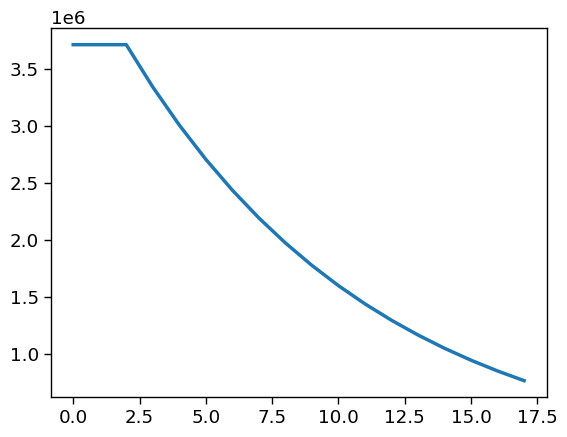

In [30]:
timeHorizon = 15
list_vehicule = ['Diesel', 'Electrique et hydrogène', 'Essence']
# emission budget

# initial emission budget as the emission of the region in 2019 in tCO2 
initial_emission_budget = np.sum([dict_emission[i] * dict_modes[i] for i in list_modes if not (i in ['voiture', 'sobriety'])])\
      + np.sum([dict_emission_vehicule[i] * dict_vehicle_total[i] * dict_distance_moyenne_vehicle[i] for i in list_vehicule])

initial_emission_budget = 1.2* initial_emission_budget

# each years the emission budget decrease by 10% 
emission_budget = [initial_emission_budget] *2+  [initial_emission_budget * (0.9)**(t) for t in range(timeHorizon+1)]
plt.plot(emission_budget)
# money budget

money_budget = [5e4 for t in range(timeHorizon+1)]

# disctance budget

distance_budget = [mpkm for t in range(timeHorizon+1)]
print(sum(money_budget))

In [31]:

# Create the model
model = TransportModel(timeHorizon, 
                       list_modes, dict_modes, distance_budget,
                       dict_infra, dict_depreciation_infra, 
                       list_vehicule, dict_vehicle_total, dict_vehicule_region, dict_distance_moyenne_vehicle, duree_de_vie_vehicule, dict_emission_vehicule,
                       dict_emission, cost_sobriety=cout_sob, cost_vehicle_switch=couts_switch_vehicule, cost_vehicule_buy=dict_couts_achat_vehicule, cost_modes_switch=couts_switch_modes, cost_infra_invest=dict_couts_invest_infra,
                          service_quality=dict_qualite_service, emission_budget=emission_budget, money_budget=money_budget)
model.build_model()


model.solve()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-21
Read LP format model from file C:\Users\ANTHON~1\AppData\Local\Temp\tmp36ceivs0.pyomo.lp
Reading time = 0.02 seconds
x1: 683 rows, 1348 columns, 3285 nonzeros
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12800H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 683 rows, 1348 columns and 3285 nonzeros
Model fingerprint: 0xb9054d2c
Model has 80 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 3e+04]
  QMatrix range    [1e-02, 2e+00]
  Objective range  [5e-01, 5e+02]
  Bounds range     [5e-02, 1e+05]
  RHS range        [5e-03, 4e+06]
Presolve removed 165 rows and 355 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 253 rows and 439 columns
Presolve time: 0.01s
Presolved: 1465 rows, 1164

['voiture', 'tram', 'bus', 'marche', 'velo', 'train', 'sobriety']


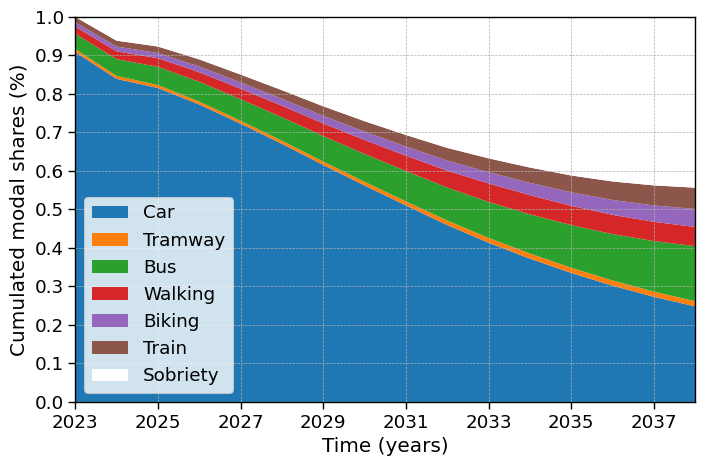

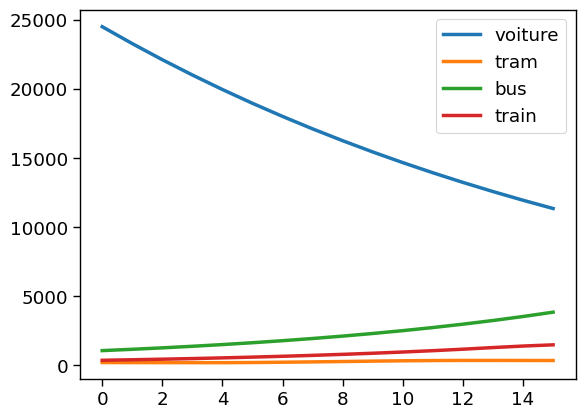

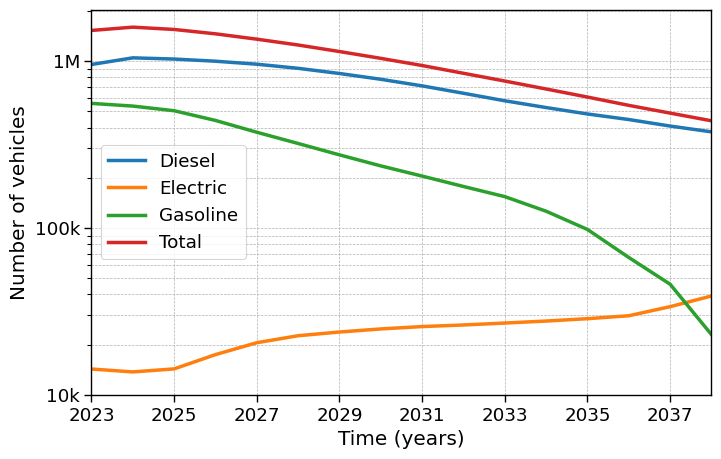

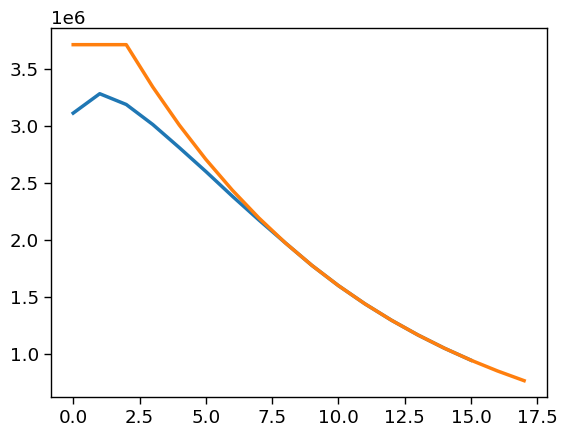

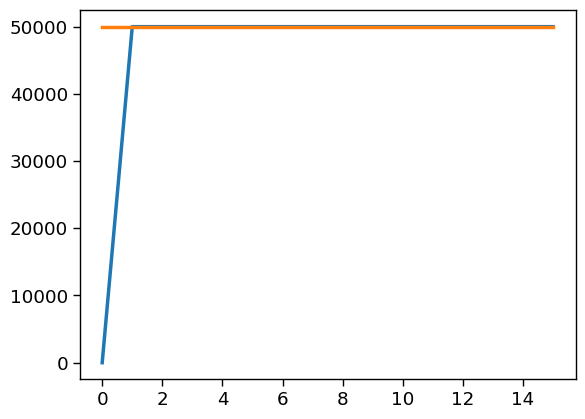

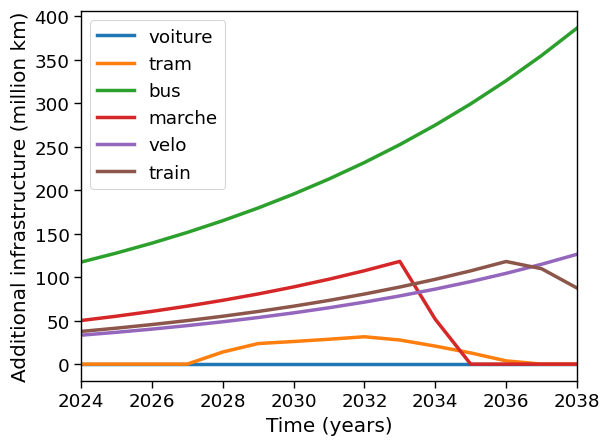

\begin{tabular}{lrrrrrrr}
\toprule
\midrule
0 & 0 & 36.044 & 33.785 & 2.259 & 750.000 & 750.000 & 50.000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
\midrule
Infrastructure & 553223.192 \\
Vehicle & 173939.677 \\
Modes & 383377.601 \\
Sobriety & 1220534.474 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
\midrule
Infrastructure & 23.733 \\
Vehicle & 7.462 \\
Modes & 16.446 \\
Sobriety & 52.359 \\
\bottomrule
\end{tabular}



,Investment,Budget (%)
0,Infrastructure,23.732536
1,Vehicle,7.461780
2,Modes,16.446387
3,Sobriety,52.359298


In [32]:
# Plot the results
# as staked plot

data_to_stack = np.array([[model.m.usage[mode, t].value for t in model.m.time] for mode in model.m.modes])/mpkm
list_color = sns.color_palette("tab10", len(model.m.modes))
# change sobriety color to white
list_color[-1] = (1, 1, 1)

plt.figure(figsize=(8, 5), dpi=100)
plt.stackplot(model.m.time, data_to_stack, colors=list_color)
# modes in english
print([mode for mode in model.m.modes]) # ['voiture', 'tram', 'bus', 'marche', 'velo', 'train', 'sobriety']
plt.legend(['Car', 'Tramway', 'Bus', 'Walking', 'Biking', 'Train', 'Sobriety'], loc='lower left')
plt.xlabel('Time (years)')
plt.ylabel('Cumulated modal shares (%)')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, timeHorizon)
plt.xticks(np.arange(0, timeHorizon+1, 2), np.arange(0, timeHorizon+1, 2) + 2023)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('figs/usage_proportion.pdf', bbox_inches='tight',format='pdf')

plt.show()


plt.plot([model.m.infra_park['voiture', t].value for t in model.m.time])
plt.plot([model.m.infra_park['tram', t].value for t in model.m.time])
plt.plot([model.m.infra_park['bus', t].value for t in model.m.time])
plt.plot([model.m.infra_park['train', t].value for t in model.m.time])
plt.legend(['voiture', 'tram', 'bus', 'train'])
plt.show()

plt.figure(figsize=(8, 5), dpi=100)
plt.plot([model.m.vehicle_park['Diesel', t].value for t in model.m.time])
plt.plot([model.m.vehicle_park['Electrique et hydrogène', t].value for t in model.m.time])
plt.plot([model.m.vehicle_park['Essence', t].value for t in model.m.time])
# plot the sum of the three kind of vehicle in english ['Diesel', 'Electrique et hydrogène', 'Essence']

plt.plot([sum([model.m.vehicle_park[vehicle, t].value for vehicle in model.m.vehicle]) for t in model.m.time])

# kind of vehicle in english ['Diesel', 'Electrique et hydrogène', 'Essence']
plt.legend(['Diesel', 'Electric', 'Gasoline', 'Total'])
plt.xlabel('Time (years)')
plt.ylabel('Number of vehicles')
plt.xlim(0, timeHorizon)
plt.xticks(np.arange(0, timeHorizon+1, 2), np.arange(0, timeHorizon+1, 2) + 2023)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.yticks([10000, 100000, 1000000], ['10k', '100k', '1M'])

plt.savefig('figs/vehicle_park.pdf', bbox_inches='tight',format='pdf')
plt.show()

plt.plot([value(model.emission_expression(t)) for t in model.m.time])
plt.plot(emission_budget)
plt.show()

plt.plot([value(model.money_expression(t)) for t in model.m.time])
plt.plot(money_budget)
plt.show()

# plt the investment in infrastructure
data_to_plot = np.array([[model.m.infra_invest[infra, t].value  for t in model.m.time if t!=0] for infra in model.m.list_infra])
plt.plot(np.arange(0,len(model.m.time)-1), data_to_plot.T)
plt.legend(model.m.list_infra)

plt.xlabel('Time (years)')
plt.ylabel('Additional infrastructure (million km)')
plt.xticks(np.arange(0, timeHorizon, 2), np.arange(0, timeHorizon, 2) + 2024)
plt.xlim(0, timeHorizon-1)

plt.show()

data = {
    'Time (years)': [0],
    'Constraint (MtCO2e)': [sum(np.array(emission_budget[:-2])) / 1e6],
    'Emission budget (MtCO2e)': [sum([round(value(model.emission_expression(t)), 2) / 1e6 for t in model.m.time])],
    'Difference (MtCO2e)': [abs(sum([round(value(model.emission_expression(t)), 2) / 1e6 for t in model.m.time]) - sum(np.array(emission_budget[:-2]) / 1e6))],
    'Budget (€)': [sum(money_budget[1:])/1e3],
    'Money spent (€)': [sum([round(value(model.money_expression(t)), 2) for t in model.m.time] ) / 1e3],
    'Difference (€)': [abs(sum([round(value(model.money_expression(t)), 2) for t in model.m.time]) - sum(money_budget)) / 1e3]
    }
data = pd.DataFrame(data)


print(data.to_latex(index=True, header=False, float_format="%.3f"))

# generation of latex table for representing the budget allocated at each kind of investment

money_infra = sum([model.m.infra_invest[infra, t].value * model.m.cost_infra_invest[infra] for infra in model.m.list_infra for t in model.m.time if t!=0])

money_vehicle_switch = sum([model.m.vehicle_switch[i,j,t].value * model.m.cost_vehicle_switch[i][j] for i in model.m.vehicle for j in model.m.vehicle for t in model.m.time if t!=0])

money_vehicle_buy = sum([model.m.vehicle_buy[i,t].value * model.m.cost_vehicule_buy[i] for i in model.m.vehicle for t in model.m.time if t!=0])

money_vehicle = money_vehicle_switch + money_vehicle_buy

money_modes_switch = sum([model.m.switch[i,j,t].value * model.m.cost_modes_switch[i][j] *model.m.total_km[t] for i in model.m.modes  for j in model.m.modes if j!='sobriety' for t in model.m.time if t!=0])

money_sobriety_switch = sum([model.m.switch[i,'sobriety',t].value * model.m.cost_modes_switch[i]['sobriety'] *model.m.total_km[t] for i in model.m.modes  for t in model.m.time if t!=0])

money_sobriety = sum([model.m.usage['sobriety',t].value * model.m.cost_sobriety for t in model.m.time if t!=0]) + money_sobriety_switch


data = {
    'Investment': ['Infrastructure', 'Vehicle', 'Modes', 'Sobriety'],
    'Budget (€)': [money_infra, money_vehicle, money_modes_switch, money_sobriety]
    }

data = pd.DataFrame(data)

print(data.to_latex(index=False, header=False, float_format="%.3f"))

# generation of latex table for representing the investment in infrastructure

# proportion of the budget allocated at each kind of investment in %

total_budget = money_infra + money_vehicle + money_modes_switch + money_sobriety

data = {
    'Investment': ['Infrastructure', 'Vehicle', 'Modes', 'Sobriety'],
    'Budget (%)': [money_infra/total_budget*100, money_vehicle/total_budget*100, money_modes_switch/total_budget*100, money_sobriety/total_budget*100]
    }

data = pd.DataFrame(data)

print(data.to_latex(index=False, header=False, float_format="%.3f"))
data

### higher budget

8000000.0


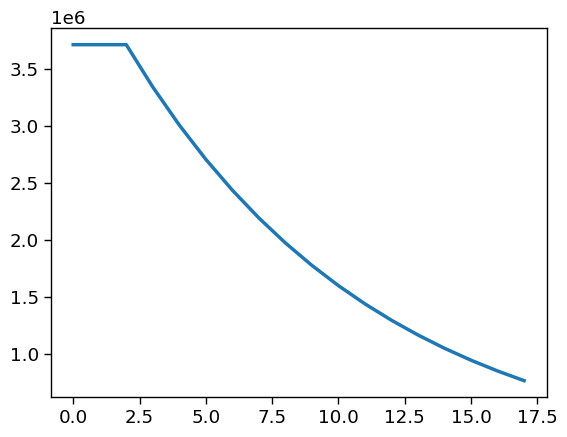

In [33]:
timeHorizon = 15
list_vehicule = ['Diesel', 'Electrique et hydrogène', 'Essence']
# emission budget

# initial emission budget as the emission of the region in 2019 in tCO2 
initial_emission_budget = np.sum([dict_emission[i] * dict_modes[i] for i in list_modes if not (i in ['voiture', 'sobriety'])])\
      + np.sum([dict_emission_vehicule[i] * dict_vehicle_total[i] * dict_distance_moyenne_vehicle[i] for i in list_vehicule])

initial_emission_budget = 1.2* initial_emission_budget

# each years the emission budget decrease by 10% 
emission_budget = [initial_emission_budget] *2+  [initial_emission_budget * (0.9)**(t) for t in range(timeHorizon+1)]
plt.plot(emission_budget)
# money budget

money_budget = [50e4 for t in range(timeHorizon+1)]

# disctance budget

distance_budget = [mpkm for t in range(timeHorizon+1)]
print(sum(money_budget))

In [34]:

# Create the model
model = TransportModel(timeHorizon, 
                       list_modes, dict_modes, distance_budget,
                       dict_infra, dict_depreciation_infra, 
                       list_vehicule, dict_vehicle_total, dict_vehicule_region, dict_distance_moyenne_vehicle, duree_de_vie_vehicule, dict_emission_vehicule,
                       dict_emission, cost_sobriety=cout_sob, cost_vehicle_switch=couts_switch_vehicule, cost_vehicule_buy=dict_couts_achat_vehicule, cost_modes_switch=couts_switch_modes, cost_infra_invest=dict_couts_invest_infra,
                          service_quality=dict_qualite_service, emission_budget=emission_budget, money_budget=money_budget)
model.build_model()



model.solve()



Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-21
Read LP format model from file C:\Users\ANTHON~1\AppData\Local\Temp\tmp4x9a3xgv.pyomo.lp
Reading time = 0.01 seconds
x1: 683 rows, 1348 columns, 3285 nonzeros
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12800H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 683 rows, 1348 columns and 3285 nonzeros
Model fingerprint: 0xbef4a71e
Model has 80 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-03, 3e+04]
  QMatrix range    [1e-02, 2e+00]
  Objective range  [5e-01, 5e+02]
  Bounds range     [5e-02, 1e+05]
  RHS range        [5e-03, 4e+06]
Presolve removed 163 rows and 355 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 241 rows and 439 columns
Presolve time: 0.01s
Presolved: 1477 rows, 1164

['voiture', 'tram', 'bus', 'marche', 'velo', 'train', 'sobriety']


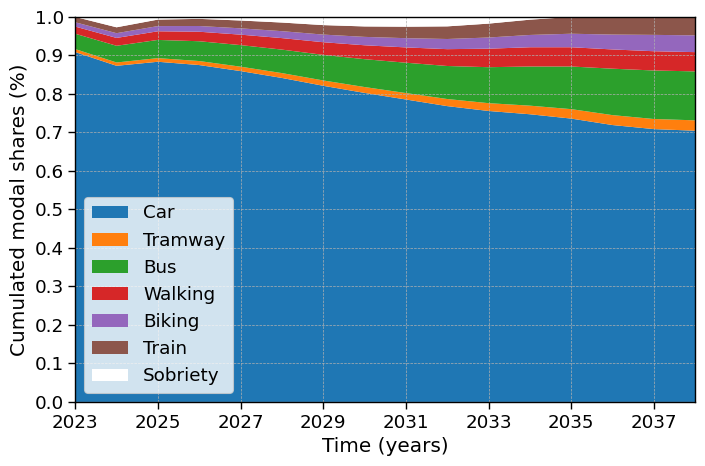

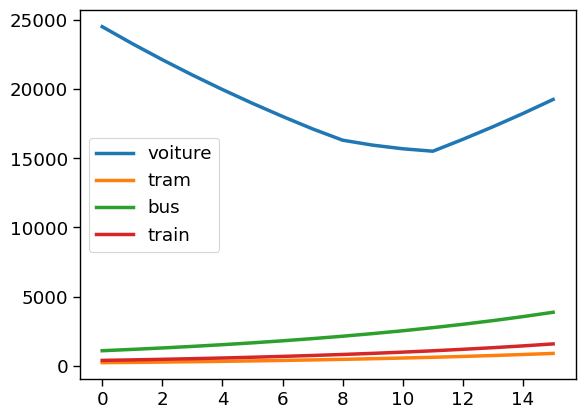

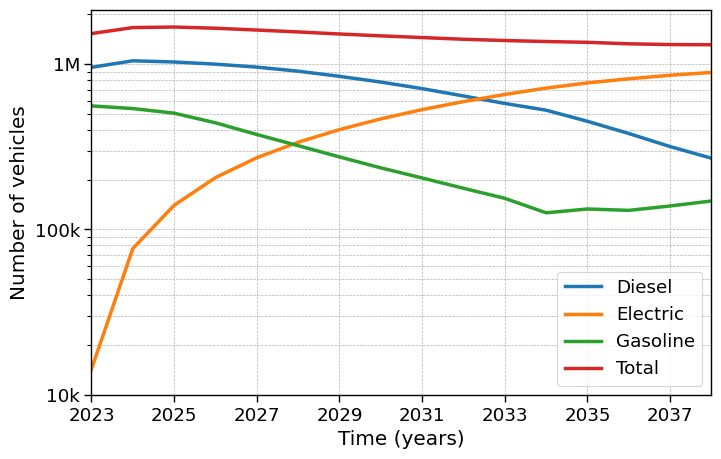

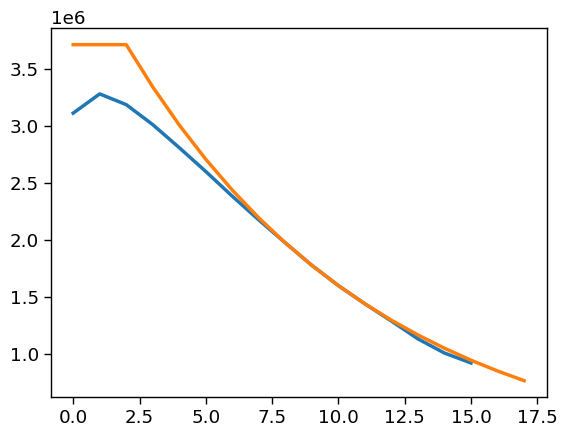

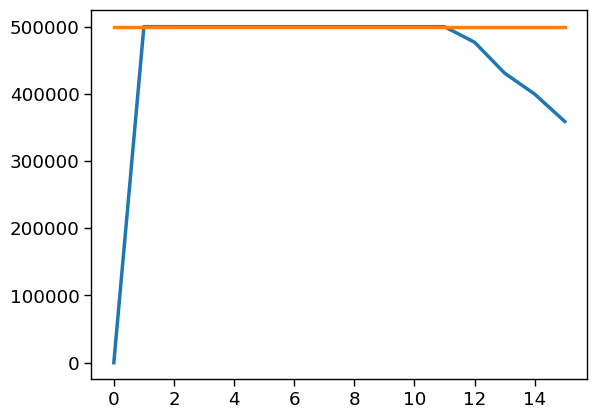

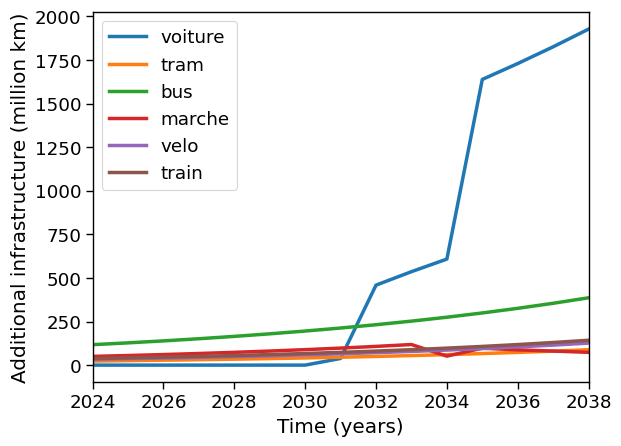

\begin{tabular}{lrrrrrrr}
\toprule
\midrule
0 & 0 & 36.044 & 33.671 & 2.373 & 7500.000 & 7166.345 & 833.655 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
\midrule
Infrastructure & 1007748.011 \\
Vehicle & 6157498.929 \\
Modes & 905904.236 \\
Sobriety & 2016148.220 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
\midrule
Infrastructure & 9.990 \\
Vehicle & 61.042 \\
Modes & 8.981 \\
Sobriety & 19.987 \\
\bottomrule
\end{tabular}



,Investment,Budget (%)
0,Infrastructure,9.990266
1,Vehicle,61.042095
2,Modes,8.980642
3,Sobriety,19.986997


In [35]:
# Plot the results
# # paper style
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

# as staked plot

data_to_stack = np.array([[model.m.usage[mode, t].value for t in model.m.time] for mode in model.m.modes])/mpkm
list_color = sns.color_palette("tab10", len(model.m.modes))
# change sobriety color to white
list_color[-1] = (1, 1, 1, 1)

plt.figure(figsize=(8, 5), dpi=100)
plt.stackplot(model.m.time, data_to_stack, colors=list_color)
# modes in english
print([mode for mode in model.m.modes]) # ['voiture', 'tram', 'bus', 'marche', 'velo', 'train', 'sobriety']
plt.legend(['Car', 'Tramway', 'Bus', 'Walking', 'Biking', 'Train', 'Sobriety'], loc='lower left')
plt.xlabel('Time (years)')
plt.ylabel('Cumulated modal shares (%)')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, timeHorizon)
plt.xticks(np.arange(0, timeHorizon+1, 2), np.arange(0, timeHorizon+1, 2) + 2023)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('figs/usage_proportion_higher.pdf', bbox_inches='tight',format='pdf')

plt.show()


plt.plot([model.m.infra_park['voiture', t].value for t in model.m.time])
plt.plot([model.m.infra_park['tram', t].value for t in model.m.time])
plt.plot([model.m.infra_park['bus', t].value for t in model.m.time])
plt.plot([model.m.infra_park['train', t].value for t in model.m.time])
plt.legend(['voiture', 'tram', 'bus', 'train'])
plt.show()

plt.figure(figsize=(8, 5), dpi=100)
plt.plot([model.m.vehicle_park['Diesel', t].value for t in model.m.time])
plt.plot([model.m.vehicle_park['Electrique et hydrogène', t].value for t in model.m.time])
plt.plot([model.m.vehicle_park['Essence', t].value for t in model.m.time])
# plot the sum of the three kind of vehicle in english ['Diesel', 'Electrique et hydrogène', 'Essence']

plt.plot([sum([model.m.vehicle_park[vehicle, t].value for vehicle in model.m.vehicle]) for t in model.m.time])

# kind of vehicle in english ['Diesel', 'Electrique et hydrogène', 'Essence']
plt.legend(['Diesel', 'Electric', 'Gasoline', 'Total'])
plt.xlabel('Time (years)')
plt.ylabel('Number of vehicles')
plt.xlim(0, timeHorizon)
plt.xticks(np.arange(0, timeHorizon+1, 2), np.arange(0, timeHorizon+1, 2) + 2023)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.yticks([10000, 100000, 1000000], ['10k', '100k', '1M'])


plt.savefig('figs/vehicle_park_higher.pdf', bbox_inches='tight',format='pdf')
plt.show()

plt.plot([value(model.emission_expression(t)) for t in model.m.time])
plt.plot(emission_budget)
plt.show()

plt.plot([value(model.money_expression(t)) for t in model.m.time])
plt.plot(money_budget)
plt.show()

# plt the investment in infrastructure
data_to_plot = np.array([[model.m.infra_invest[infra, t].value  for t in model.m.time if t!=0] for infra in model.m.list_infra])
plt.plot(np.arange(0,len(model.m.time)-1), data_to_plot.T)
plt.legend(model.m.list_infra)

plt.xlabel('Time (years)')
plt.ylabel('Additional infrastructure (million km)')
plt.xticks(np.arange(0, timeHorizon, 2), np.arange(0, timeHorizon, 2) + 2024)
plt.xlim(0, timeHorizon-1)

plt.show()

data = {
    'Time (years)': [0],
    'Constraint (MtCO2e)': [sum(np.array(emission_budget[:-2])) / 1e6],
    'Emission budget (MtCO2e)': [sum([round(value(model.emission_expression(t)), 2) / 1e6 for t in model.m.time])],
    'Difference (MtCO2e)': [abs(sum([round(value(model.emission_expression(t)), 2) / 1e6 for t in model.m.time]) - sum(np.array(emission_budget[:-2]) / 1e6))],
    'Budget (€)': [sum(money_budget[1:])/1e3],
    'Money spent (€)': [sum([round(value(model.money_expression(t)), 2) for t in model.m.time] ) / 1e3],
    'Difference (€)': [abs(sum([round(value(model.money_expression(t)), 2) for t in model.m.time]) - sum(money_budget)) / 1e3]
    }
data = pd.DataFrame(data)


print(data.to_latex(index=True, header=False, float_format="%.3f"))

# generation of latex table for representing the budget allocated at each kind of investment

money_infra = sum([model.m.infra_invest[infra, t].value * model.m.cost_infra_invest[infra] for infra in model.m.list_infra for t in model.m.time if t!=0])

money_vehicle_switch = sum([model.m.vehicle_switch[i,j,t].value * model.m.cost_vehicle_switch[i][j] for i in model.m.vehicle for j in model.m.vehicle for t in model.m.time if t!=0])

money_vehicle_buy = sum([model.m.vehicle_buy[i,t].value * model.m.cost_vehicule_buy[i] for i in model.m.vehicle for t in model.m.time if t!=0])

money_vehicle = money_vehicle_switch + money_vehicle_buy

money_modes_switch = sum([model.m.switch[i,j,t].value * model.m.cost_modes_switch[i][j] *model.m.total_km[t] for i in model.m.modes  for j in model.m.modes if j!='sobriety' for t in model.m.time if t!=0])

money_sobriety_switch = sum([model.m.switch[i,'sobriety',t].value * model.m.cost_modes_switch[i]['sobriety'] *model.m.total_km[t] for i in model.m.modes  for t in model.m.time if t!=0])

money_sobriety = sum([model.m.usage['sobriety',t].value * model.m.cost_sobriety for t in model.m.time if t!=0]) + money_sobriety_switch


data = {
    'Investment': ['Infrastructure', 'Vehicle', 'Modes', 'Sobriety'],
    'Budget (€)': [money_infra, money_vehicle, money_modes_switch, money_sobriety]
    }

data = pd.DataFrame(data)

print(data.to_latex(index=False, header=False, float_format="%.3f"))

# generation of latex table for representing the investment in infrastructure

# proportion of the budget allocated at each kind of investment in %

total_budget = money_infra + money_vehicle + money_modes_switch + money_sobriety

data = {
    'Investment': ['Infrastructure', 'Vehicle', 'Modes', 'Sobriety'],
    'Budget (%)': [money_infra/total_budget*100, money_vehicle/total_budget*100, money_modes_switch/total_budget*100, money_sobriety/total_budget*100]
    }

data = pd.DataFrame(data)

print(data.to_latex(index=False, header=False, float_format="%.3f"))
data

## Solvability and complexity of the problem w.r.t. budget

In [36]:
class TransportModel:
    def __init__(self, T, 
                list_modes, initial_modes, total_km,
                initial_infra : dict, depreciation_infra : dict, 
                list_vehicle, initial_vehicle : dict, initial_vehicle_with_age : dict, average_distance_per_vehicle : dict, expected_lifetime_vehicle : dict,
                emission_per_km_vehicle, emission_per_km_mode,
                cost_sobriety, cost_vehicle_switch, cost_vehicule_buy, cost_modes_switch, cost_infra_invest,  
                service_quality, 
                emission_budget, money_budget):
        
        # Create a Concrete Model
        self.m = ConcreteModel()

        # Parameters
        self.m.T = T
        self.m.list_modes = list_modes
        self.m.list_infra = [i for i in list_modes if i != 'sobriety']
        self.m.initial_modes = initial_modes
        self.m.total_km = total_km # million passenger-kmn (mpkm)
        self.m.initial_infra = initial_infra 
        self.m.depreciation_infra = depreciation_infra
        self.m.list_vehicle = list_vehicle
        self.m.initial_vehicle = initial_vehicle
        self.m.initial_vehicle_with_age = initial_vehicle_with_age
        self.m.average_distance_per_vehicle = average_distance_per_vehicle # km
        self.m.expected_lifetime_vehicle = expected_lifetime_vehicle # years
        self.m.emission_per_km_vehicle = emission_per_km_vehicle # tCO2e/vehicle-mkm
        self.m.emission_per_km_mode = emission_per_km_mode # tCO2e/mode-mkm
        self.m.cost_sobriety = cost_sobriety # €
        self.m.cost_vehicle_switch = cost_vehicle_switch # €/vehicle
        self.m.cost_vehicule_buy = cost_vehicule_buy # €/vehicle
        self.m.cost_modes_switch = cost_modes_switch # €
        self.m.cost_infra_invest = cost_infra_invest # €
        self.m.service_quality = service_quality 

        # Budget

        self.m.emission_budget = emission_budget
        self.m.money_budget = money_budget

        # Sets
        self.m.time = RangeSet(0, T)

        # Usage 
        self.m.modes = Set(initialize=list_modes) # marche, velo, train, tram, bus, voiture
        self.m.usage = Var(self.m.modes, self.m.time, domain=NonNegativeReals) # passenger-km
        self.m.usage_proportion = Var(self.m.modes, self.m.time, domain=NonNegativeReals, bounds=(0,1)) # proportion of usage of each mode
        self.m.switch = Var(self.m.modes, self.m.modes, self.m.time, bounds=(0,0.025), domain=NonNegativeReals, initialize=0) # switch from one mode to another 

        # Infrastucture
        self.m.infra = Set(initialize=self.m.list_infra)
        def _bounds_rule(m, infra, time):
            return (m.initial_infra[infra] * m.depreciation_infra[infra]**time, m.initial_infra[infra] * 1.1**time)
        self.m.infra_park = Var(self.m.infra, self.m.time, domain=NonNegativeReals, bounds=_bounds_rule)
        self.m.infra_invest = Var(self.m.infra, self.m.time, domain=NonNegativeReals, initialize=0) # investment in infrastructure

        # Vehicule 
        self.m.vehicle = Set(initialize=list_vehicle)
        self.m.vehicle_park = Var(self.m.vehicle, self.m.time, domain=NonNegativeReals) # vehicle
        self.m.vehicle_buy = Var(self.m.vehicle, self.m.time, domain=NonNegativeReals, initialize=0) # vehicle buy 
        self.m.vehicle_switch = Var(self.m.vehicle, self.m.vehicle, self.m.time, domain=NonNegativeReals, initialize=0) # switch from one vehicle to another at end of life 
    

    def build_initial_conditions(self):
        # Initial conditions
        self.m.init_conditions = ConstraintList()
        for mode in self.m.list_modes:
            if mode != 'sobriety':
                self.m.init_conditions.add(self.m.usage_proportion[mode, 0] == self.m.initial_modes[mode])
            else:
                self.m.init_conditions.add(self.m.usage_proportion[mode, 0] == 0)

        for infra in self.m.list_infra:
            self.m.init_conditions.add(self.m.infra_park[infra, 0] == self.m.initial_infra[infra])

        for vehicle in self.m.vehicle:
            self.m.init_conditions.add(self.m.vehicle_park[vehicle, 0] == self.m.initial_vehicle[vehicle])

    def build_constraints(self):
        # Constraints

        # Link between usage and usage proportion
        self.m.link_usage_usage_proportion = ConstraintList()
        for mode in self.m.list_modes:
            for t in self.m.time:
                self.m.link_usage_usage_proportion.add(self.m.usage[mode, t] == self.m.usage_proportion[mode, t] * self.m.total_km[t])
        
        # Dynamics
        self.m.dynamics = ConstraintList()
        for mode in list_modes:
            for t in range(1, self.m.T+1):
                # Proportion of usage of each mode, at each time t, is equal to the proportion of usage of each mode at time t-1 + the switch from other modes to mode i - the switch from mode i to other modes
                self.m.dynamics.add(self.m.usage_proportion[mode, t] == self.m.usage_proportion[mode, t-1]\
                     + sum(self.m.switch[j, mode, t] for j in self.m.modes) - sum(self.m.switch[mode, j, t] for j in self.m.modes) )
            
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                # Usage of each infra, at each time t, is equal to the proportion of usage of each infra at time t * mpkm, where mpkm is the total km passenger want to travel 
                self.m.dynamics.add(self.m.infra_park[infra, t] == self.m.infra_park[infra, t-1] * self.m.depreciation_infra[infra]  + self.m.infra_invest[infra, t])

        for vehicle in self.m.vehicle:
            for t in range(1, self.m.T+1):
                if t <= self.m.expected_lifetime_vehicle[vehicle]:
                    # Evolution of the number of vehicle in circulation, at each time t, is equal to the number of vehicle in circulation at time t-1 + the number of vehicle bought at time t + the number of vehicle switched to vehicle i - the number of vehicle that are at the end of their life
                    self.m.dynamics.add(self.m.vehicle_park[vehicle, t] == self.m.vehicle_park[vehicle, t-1] \
                                            + self.m.vehicle_buy[vehicle, t] + sum(self.m.vehicle_switch[j, vehicle, t] for j in self.m.vehicle) \
                                            - self.m.initial_vehicle_with_age[vehicle][t-1]
                                            )
                else:
                    # Evolution of the number of vehicle in circulation, at each time t, is equal to the number of vehicle in circulation at time t-1 - the number of vehicle that are at the end of their life + the number of vehicle bought at time t + the number of vehicle switched to vehicle i
                    self.m.dynamics.add(self.m.vehicle_park[vehicle, t] == self.m.vehicle_park[vehicle, t-1] \
                                            - self.m.vehicle_buy[vehicle, t-self.m.expected_lifetime_vehicle[vehicle]] - sum(self.m.vehicle_switch[j, vehicle, t-self.m.expected_lifetime_vehicle[vehicle]] for j in self.m.vehicle) \
                                            + self.m.vehicle_buy[vehicle, t] + sum(self.m.vehicle_switch[j, vehicle, t] for j in self.m.vehicle)
                                            )
                    
        # Capacity
        self.m.capacity = ConstraintList()
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                if infra == 'voiture' :
                    # At each time t, the number of vehicle in circulation is less than the capacity of the infrastructure
                    self.m.capacity.add(
                        sum(self.m.vehicle_park[j, t] * self.m.average_distance_per_vehicle[j] for j in self.m.vehicle) <= self.m.infra_park[infra, t]
                        )
                else:
                    # At each time t, the usage of mode i is less than the capacity of the infrastructure
                    self.m.capacity.add(
                        self.m.usage[infra, t] <= self.m.infra_park[infra, t]
                        )

        # Vehicle constraints
        self.m.vehicle_constraints = ConstraintList()
        for vehicle in self.m.vehicle:
            for t in range(1, self.m.T+1):
                if t <= self.m.expected_lifetime_vehicle[vehicle]:
                    # At each time t, the number of vehicle that are switched to vehicle i is less than the number of vehicle that are at the end of their life
                    self.m.vehicle_constraints.add(
                        sum(self.m.vehicle_switch[vehicle, j, t] for j in self.m.vehicle) <= self.m.initial_vehicle_with_age[vehicle][self.m.expected_lifetime_vehicle[vehicle]-t]
                        )
                else:
                    # At each time t, the number of vehicle that are switched to vehicle i is less than the number of vehicle that are bought at time t-expected_lifetime_vehicle[i]
                    self.m.vehicle_constraints.add(
                        sum(self.m.vehicle_switch[vehicle, j, t] for j in self.m.vehicle) <= self.m.vehicle_buy[vehicle, t-self.m.expected_lifetime_vehicle[vehicle]]
                        )
                    
        # Mobility constraint
        self.m.mobility_constraint = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the usage of car is less than the number of vehicle in circulation (to avoid having usage of car without car in circulation)
            self.m.mobility_constraint.add(
                self.m.usage['voiture', t] <= sum(self.m.vehicle_park[i, t] * self.m.average_distance_per_vehicle[i] * 1.3 for i in self.m.vehicle)
                )
            
        # Budget constraints

        self.m.budget_constraint = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the emission is less than the emission budget
            self.m.budget_constraint.add(
                self.emission_expression(t)/1e3 <= emission_budget[t]/1e3
                )
            # At each time t, the money spent is less than the money budget
            self.m.budget_constraint.add(
                self.money_expression(t)/1e3 == money_budget[t]/1e3
                )
            
        # # Constraints on modes
        self.m.mode_constraints = ConstraintList()
        for t in range(1, self.m.T+1):
            # At each time t, the usage of marche is less than 5% of the total km
            self.m.mode_constraints.add(
                self.m.usage_proportion['marche', t] <= 0.05
                )
            
            self.m.mode_constraints.add(
                self.m.usage_proportion['marche', t] >= 0.005 
                )


            # At each time t, the usage of velo is less than 20% of the total km
            self.m.mode_constraints.add(
                self.m.usage['velo', t] <= 0.02 * self.m.total_km[t]* 1.1**t
                )

        self.m.infra_invest_constraint = ConstraintList()
        for infra in self.m.list_infra:
            for t in range(1, self.m.T+1):
                self.m.infra_invest_constraint.add(self.m.infra_invest[infra, t] <= self.m.infra_park[infra, t] * 0.1)
            
        
    def emission_expression(self, t):
        return sum(self.m.usage[i, t] * self.m.emission_per_km_mode[i] for i in self.m.modes if i != 'voiture')\
              + sum(self.m.vehicle_park[i, t] * self.m.emission_per_km_vehicle[i] * self.m.average_distance_per_vehicle[i] for i in self.m.vehicle)
    
    def money_expression(self, t):
        return sum(self.m.infra_invest[i, t] * self.m.cost_infra_invest[i] for i in self.m.infra) \
            + sum(self.m.vehicle_switch[i,j,t] * self.m.cost_vehicle_switch[i][j] for i in self.m.vehicle for j in self.m.vehicle) \
            + sum(self.m.vehicle_buy[i,t] * self.m.cost_vehicule_buy[i] for i in self.m.vehicle) \
            + self.m.usage['sobriety',t] * self.m.cost_sobriety \
            + sum(self.m.switch[i,j,t] * self.m.cost_modes_switch[i][j] for i in self.m.modes for j in self.m.modes)
    
    def build_piecewise_approximation(self):
        
        # Voiture mode

        self.m.qos_voiture = Var(self.m.time, domain=NonNegativeReals)


        # Constraint to calculate the ratio v/y
        def qos_voiture_up(model, time):
                return model.qos_voiture[time] * model.infra_park['voiture', time] == model.usage_proportion['voiture', time] * model.service_quality['voiture'] *( model.infra_park['voiture', time] -  sum( model.vehicle_park[vehicle, time] * self.m.average_distance_per_vehicle[vehicle] for vehicle in  model.vehicle) )

        self.m.qos_voiture_up = Constraint(self.m.time, rule=qos_voiture_up)

        # other modes

        self.m.qos = Var(self.m.infra - ['voiture'], self.m.time, domain=NonNegativeReals)

        # Constraint to calculate the ratio v/y
        def qos_up(model, infra, time):
                if infra == 'voiture' or infra == 'marche':
                    return Constraint.Skip
                return model.qos[infra, time] * model.infra_park[infra, time] / model.total_km[time] == model.usage_proportion[infra, time] * model.service_quality[infra] *( model.infra_park[infra, time] -  model.usage[infra, time] )

        self.m.qos_up = Constraint(self.m.infra - ['voiture', 'marche'], self.m.time, rule=qos_up)

    def objective_function(self, model):
        # Modify the existing objective function to include the piecewise linear approximation
        return (sum(model.qos[infra, time] for infra in model.infra - ['voiture', 'marche'] for time in model.time) +
                sum(model.usage['marche', time] * model.service_quality['marche'] for time in model.time) +
                sum(model.qos_voiture[time] for time in model.time) -
                sum(model.usage['sobriety', time] for time in model.time)*200 )

    def build_model(self):
        self.build_initial_conditions()
        self.build_constraints()
        self.build_piecewise_approximation()
        self.m.obj = Objective(rule=self.objective_function, sense=maximize)

    def build_model_without_piecewise(self):
        self.build_initial_conditions()
        self.build_constraints()
        self.m.obj = Objective(rule=0, sense=maximize)



    def solve(self):
        solver = SolverFactory('gurobi')
        solver.options['ScaleFlag'] = 3
        solver.options['NumericFocus'] = 0
        # solver.options['FeasibilityTol'] = 1e-9
        # solver.options['Aggressiveness'] = 2
        # solver.options['ConcurrentMIP'] = 5
        solver.options['NonConvex'] = 2
        # solver.options['BranchDir'] = -1
        # solver.options['Cuts'] = 2
        solver.options['MIPFocus'] = 3
        # solver.options['OBBT'] =3
        solver.options['TimeLimit'] = 300

        results = solver.solve(self.m, tee=True)

        print(results)

    




In [ ]:
discretization_money = 20
discretization_emission = 20

time_limit = 10

import logging
from tqdm import tqdm
import random
import time
from itertools import product


logging.getLogger('pyomo.core').setLevel(logging.ERROR)



# # plot the feasibility region of the op for different initial values of the emission budget and the money budget

# # Discretize the feasible region

initial_emission_budget = np.sum([dict_emission[i] * dict_modes[i] for i in list_modes if not (i in ['voiture', 'sobriety'])])\
      + np.sum([dict_emission_vehicule[i] * dict_vehicle_total[i] * dict_distance_moyenne_vehicle[i] for i in list_vehicule])

initial_emission_budget = 1.2* initial_emission_budget

# Define the range of emission budget and money budget
delta_range =  np.linspace(0.85,1,discretization_emission)
money_budget_range = np.linspace(30, 5e5, discretization_money)
# Create a meshgrid of the emission and money budget values
delta_range_values, money_budget_values = np.meshgrid(delta_range, money_budget_range)



dict_depreciation_infra = {'voiture': 0.95, 'tram': 0.99, 'bus': 0.98, 'marche': 1, 'velo': .99, 'train': 1}

feasibility_level = np.ones((len(delta_range), len(money_budget_range))) * -1


# Create a 2D array to store the feasibility of each point
feasibility = np.ones((len(delta_range), len(money_budget_range))) * -1

# shuffling the order of the points


idx_i = list(range(discretization_emission))
idx_j = list(range(discretization_money))
random.shuffle(idx_i)
random.shuffle(idx_j)


list_i_j = list(product(idx_i, idx_j))

# shuffling the order of the points
random.shuffle(list_i_j)


solver = SolverFactory('gurobi')
solver.options['ScaleFlag'] = 3
solver.options['NumericFocus'] = 0
# solver.options['FeasibilityTol'] = 1e-9
# solver.options['Aggressiveness'] = 2
# solver.options['ConcurrentMIP'] = 5
solver.options['NonConvex'] = 2
# solver.options['BranchDir'] = -1
# solver.options['Cuts'] = 2
solver.options['MIPFocus'] = 3
# solver.options['OBBT'] =3
solver.options['TimeLimit'] = time_limit


times = np.zeros((len(delta_range), len(money_budget_range)))
sob = np.zeros((len(delta_range), len(money_budget_range)))

for i,j in tqdm(list_i_j, position=0, leave=True):
    # for j in idx_j:
    # Update the emission and money budget values
    initial_emission_budget_ = initial_emission_budget
    delta = delta_range[i]
    emission_budget = [initial_emission_budget_] + [initial_emission_budget_ * (delta)**t for t in range(timeHorizon+1)]
    if times[i,j] == 0:

        money_budget = [money_budget_range[j]] * (timeHorizon + 1)
        model = TransportModel(timeHorizon, 
                        list_modes, dict_modes, distance_budget,
                        dict_infra, dict_depreciation_infra, 
                        list_vehicule, dict_vehicle_total, dict_vehicule_region, dict_distance_moyenne_vehicle, duree_de_vie_vehicule, dict_emission_vehicule,
                        dict_emission, cost_sobriety=cout_sob, cost_vehicle_switch=couts_switch_vehicule, cost_vehicule_buy=dict_couts_achat_vehicule, cost_modes_switch=couts_switch_modes, cost_infra_invest=dict_couts_invest_infra,
                            service_quality=dict_qualite_service, emission_budget=emission_budget, money_budget=money_budget)

        model.build_model()


        # Solve the model
        # try to solve without warning 
        tic = time.time()
        results = solver.solve(model.m, tee=False,timelimit=time_limit)
        toc = time.time()
        # print(type(results.solver.status))


        if results.solver.status == SolverStatus.ok:
            times[i,j] = toc-tic
            sob[i,j] = sum([model.m.usage['sobriety',t].value for t in model.m.time if t!=0]/ sum(model.m.total_km[t] for t in model.m.time if t!=0))
        elif results.solver.status == SolverStatus.aborted:
            times[i,j] = time_limit
            times[i:,j:] = time_limit
            sob[i,j] = 50
        
        elif results.solver.status == SolverStatus.warning:
            times[i,j] = -1
            times[:i,:j] = -1
            sob[i,j] = -1


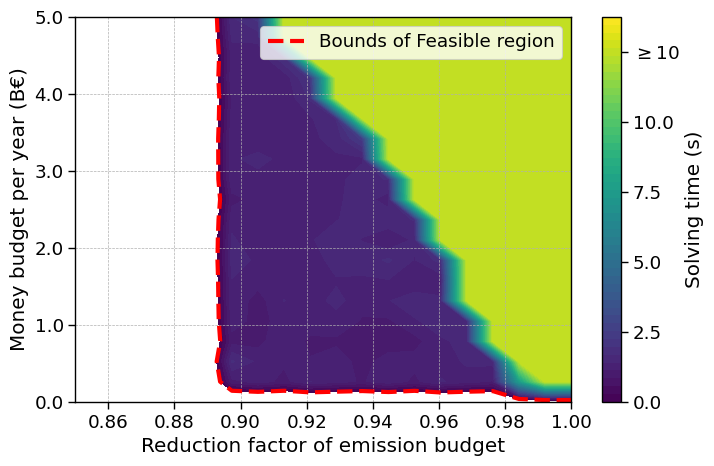

In [ ]:
# plot the times

plt.figure(figsize=(8, 5), dpi=100)
plt.contourf(delta_range, money_budget_range, times.T, list(np.linspace(0, time_limit+1, 50)), cmap='viridis')
# plt the feasibility region
cb = plt.colorbar(label='Solving time (s)', ticks=np.linspace(0, time_limit, 6))
cb.set_ticklabels([str(i) for i in np.linspace(0, time_limit, 5,endpoint=True)] + ['$\\geq${}'.format(time_limit)])
plt.contour(delta_range, money_budget_range, times.T, [0], colors='red', linewidths=3, linestyles='--')
# legend for the red line from the contour plot
# create the handle for the red line
red_line = plt.Line2D([0], [0], color='red', linewidth=3, linestyle='--', label='Bounds of Feasible region')
# add the legend to the plot
plt.legend(handles=[red_line], loc='upper right')


plt.xlabel('Reduction factor of emission budget')

plt.ylabel('Money budget per year (B€)')
# plt.yscale('symlog')

plt.yticks(np.linspace(0, 5e5, 6), np.linspace(0, 5e5, 6)/1e5)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # np.arange(0, 2.1e4, 25e2)/1e3)
# dvide by 1e3 the y ticks and remove the XX.0 in the y axis for the values that are integers
# plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:.0f}"))

# plt.title('Time to solve the optimization problem')

plt.savefig('times_{}_.pdf'.format('1301_07_06'), bbox_inches='tight',format='pdf')

plt.show()

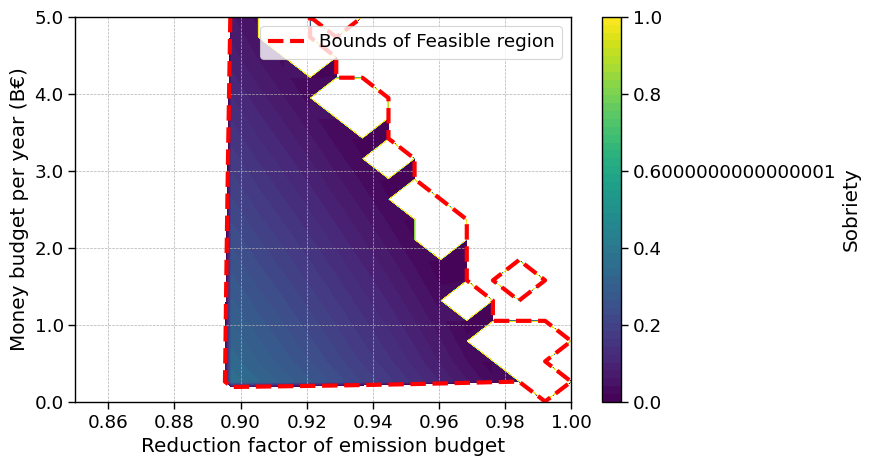

In [ ]:
# plot the sobriety

plt.figure(figsize=(8, 5), dpi=100)
plt.contourf(delta_range, money_budget_range, sob.T, list(np.linspace(0, 1, 50)), cmap='viridis')
# plt the feasibility region
cb = plt.colorbar(label='Sobriety', ticks=np.linspace(0, 1, 6))
cb.set_ticklabels([str(i) for i in np.linspace(0, 1, 6,endpoint=True)])
plt.contour(delta_range, money_budget_range, sob.T, [0], colors='red', linewidths=3, linestyles='--')
# legend for the red line from the contour plot
# create the handle for the red line
red_line = plt.Line2D([0], [0], color='red', linewidth=3, linestyle='--', label='Bounds of Feasible region')
# add the legend to the plot
plt.legend(handles=[red_line], loc='upper right')


plt.xlabel('Reduction factor of emission budget')

plt.ylabel('Money budget per year (B€)')

plt.yticks(np.linspace(0, 5e5, 6), np.linspace(0, 5e5, 6)/1e5)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


# plt.savefig('sob_{}_.pdf'.format('1301_07_06'), bbox_inches='tight',format='pdf')

plt.show()

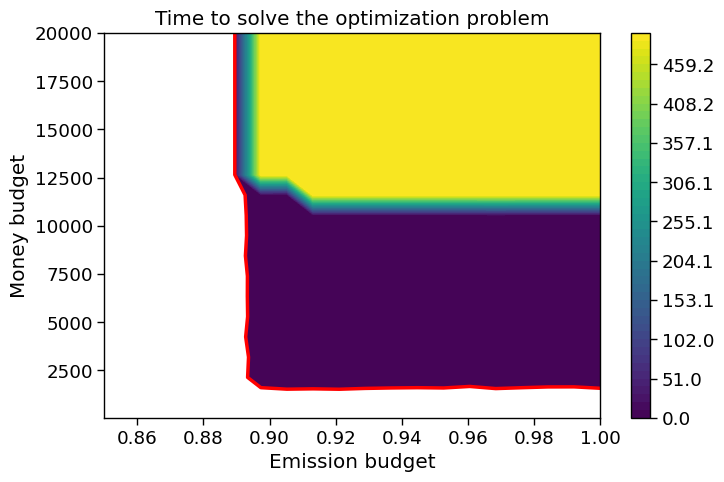

In [ ]:
# plot the times

plt.figure(figsize=(8, 5), dpi=100)
plt.contourf(delta_range, money_budget_range, times.T, list(np.linspace(0, time_limit+1, 50)), cmap='viridis')
# plt the feasibility region
plt.colorbar()
plt.contour(delta_range, money_budget_range, times.T, [0], colors='red')
plt.xlabel('Emission budget')
plt.ylabel('Money budget')
plt.title('Time to solve the optimization problem')

plt.show()